In [1]:
# Imports
import time
import copy
import itertools
import os
import shutil
from tempfile import NamedTemporaryFile
import warnings
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, OptimizeResult
from scipy.integrate import solve_ivp
from scipy.stats import norm, uniform
from joblib import Parallel, delayed
from collections import deque
import re

In [2]:
#ASA Optimizer

def vfsa_accprob(curr_cost, new_cost, temp_acc):
    exponent = np.clip((new_cost - curr_cost) / temp_acc, -500, 500)
    return 1 / (1 + np.exp(exponent))

def vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: # New seed for each instance/thread
        rng = np.random.default_rng()
    
    uni = rng.random(dim)
    base = 1 + 1 / (temp_gen + 1e-10)  # add small value in case of zero temp
    exponent = 2 * uni - 1
    rnd = np.sign(uni - 0.5) * temp_gen * (base**exponent - 1)
    return (log_ub - log_lb) * rnd

def vfsa_gen_params(curr_params, dim, log_lb, log_ub, temp_gen):
    log_params = np.log10(curr_params)
    
    # Calculate the maximum allowable step sizes within the bounds
    max_steps_up = log_ub - log_params
    max_steps_down = log_params - log_lb
    log_step = vfsa_gen_step(dim, -1, 1, temp_gen)
    scaled_step = np.minimum(max_steps_up, np.maximum(-max_steps_down, log_step))
    new_log_params = log_params + scaled_step
    
    return 10 ** new_log_params
        
def vfsa_generinitpoint(dim, log_lb, log_ub, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    uni = rng.random(dim)
    log_initpoints = log_lb + (log_ub - log_lb) * uni
    return 10 ** log_initpoints

def vfsa_reannealing(best_cost, best_params, curr_cost, dim, x0, tmax, tscat, data, c, temp_gen, temp0_gen, objective_function):
    log_orig_best_params = np.log10(best_params)
    log_par_delta = log_orig_best_params + 0.01 * log_orig_best_params
    par_delta = 10 ** log_par_delta
    
    cost_delta = np.array([
        objective_function(par_delta if i == j else best_params)
        for j in range(dim)
    ])
    
    par_diff = np.clip(par_delta - best_params, 1e-10, None)  # Avoid division by zero
    s = np.abs((cost_delta - best_cost) / par_diff) * (best_params / best_cost)
    smax = np.max(s)
    
    # Ensure no division by zero or negative values
    temp_gen = np.clip(temp_gen * (smax / np.clip(s, 1e-10, None)), 1e-10, None)
    
    k_gen = (-1/c * np.log(np.clip(temp_gen / temp0_gen, 1e-10, None))) ** dim
    k_gen = np.clip(k_gen, 0, None)  # Ensure non-negative values
    
    temp0_acc = curr_cost
    temp_acc = best_cost
    k_acc = (-1/c * np.log(np.clip(temp_acc / temp0_acc, 1e-10, None))) ** dim
    
    return temp_gen, k_gen, temp0_acc, temp_acc, k_acc

def vfsa_temp(temp_gen0, c, k_gen, dim, min_temp=1e-10):
    exponent = -c * np.power(k_gen, 1/dim)
    temp = temp_gen0 * np.exp(exponent)
    return np.clip(temp, min_temp, None)

def simulated_annealing(objective_function, initial_solution, lower_bounds, upper_bounds, 
                        initial_temperature, cooling_rate, max_iterations, neighborhood_function, 
                        log_lb, log_ub, temp_gen, 
                        M=10, eps=0.0, min_temp=1e-10, verbose=False):
    
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temperature

    reanneal_cost_vec = [best_cost]
    diff = deque(maxlen=M)
    best_diff = deque(maxlen=M)
    count_acc_points = 0

    for iteration in range(max_iterations):
        # Generate a new solution in the neighborhood
        new_solution = neighborhood_function(current_solution, len(current_solution), log_lb, log_ub, temp_gen)
        new_cost = objective_function(new_solution)
        delta_cost = new_cost - current_cost
        
        # Acceptance probability
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / temperature):
            current_solution = new_solution
            current_cost = new_cost
            count_acc_points += 1
            
            # Update the best solution found
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            # Reannealing: Store the best cost at this point
            reanneal_cost_vec.append(best_cost)
            if len(reanneal_cost_vec) > 1:
                diff.append(abs(reanneal_cost_vec[-1] - reanneal_cost_vec[-2]))
                best_diff.append(abs(reanneal_cost_vec[-1] - best_cost))

                # Termination condition based on the last M accepted costs
                if len(diff) == M and all(d <= eps for d in diff) and all(bd <= eps for bd in best_diff):
                    print('ASA converged, terminating at', iteration)
                    break
        
        # Decrease the temperature with a check for minimum temperature
        temperature = max(min_temp, temperature * cooling_rate)
        
        # Progress print statements
        if iteration % (max_iterations // 10) == 0:
            print(f"Iteration {iteration}: Current cost = {current_cost}, Best cost = {best_cost}", flush=verbose)
            print(f"Current solution: {current_solution}", flush=verbose)
        
    return best_solution, best_cost

def ASA(objective_function, x0, bounds, maxiter=100, initial_temp=1.0, cooling_rate=0.95, 
        neighborhood_function=vfsa_gen_params, init_function=vfsa_generinitpoint, 
        **kwargs):
    
    dim = len(x0)
    lower_bounds, upper_bounds = np.array(bounds).T
    log_lb, log_ub = np.log10(lower_bounds), np.log10(upper_bounds)
    log_bounds = list(zip(log_lb, log_ub))
    initial_solution = init_function(dim, log_lb, log_ub)
    
    # Run ASA optimization
    best_solution, best_cost = simulated_annealing(
        objective_function, initial_solution, lower_bounds, upper_bounds,
        initial_temp, cooling_rate, maxiter, neighborhood_function,
        log_lb, log_ub, initial_temp, verbose=True,
        **kwargs
    )
    print('ASA best cost:', best_cost)
    print(best_solution)

    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'options': {
            'disp': True,
            'maxiter': 250,
        }
    }

    local_result = minimize(
        objective_function,
        x0=best_solution,
        bounds=bounds,
        **minimizer_kwargs
    )
    
    final_solution = local_result.x
    final_cost = local_result.fun
    nfev = local_result.nfev
    success = local_result.success

    return OptimizeResult(x=final_solution, fun=final_cost, nfev=nfev, success=success)

In [3]:
# Infrastructure functions
def calculate_mean_patient_data(patients, data_key):
    all_data = []
    for patient in patients.values():
        df = patient.df[['DAY', data_key]].copy()
        df.loc[df[data_key] < 1, data_key] = 1
        all_data.append(df)

    combined_data = pd.concat(all_data)
    mean_data = combined_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).mean()).reset_index()
    std_data = combined_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).std()).reset_index()

    return mean_data, std_data

def calculate_mean_twin_data(twin_data, data_key):
    twin_data = twin_data[['DAY', data_key]].copy()
    twin_data.loc[twin_data[data_key] < 1, data_key] = 1

    mean_data = twin_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).mean()).reset_index()
    std_data = twin_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).std()).reset_index()

    return mean_data, std_data

class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, dist='uniform', method='fixed', space='log10', dtype=np.float32):
        self.name = name
        self.dtype = dtype
        self.space = space
        self.l_lim = l_lim
        self.u_lim = u_lim
        self.dist = self._create_distribution(dist, l_lim, u_lim)
        self.val = self._convert_to_type(val if val is not None else self.sample_prior())
        self.method = method

    def _transform_bound(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _inverse_transform(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _create_distribution(self, dist, l_lim, u_lim):
        if self.space == 'log10':
            l_lim_transformed = np.log10(l_lim)
            u_lim_transformed = np.log10(u_lim)
        else:
            l_lim_transformed = l_lim
            u_lim_transformed = u_lim
        
        if dist == 'uniform':
            return uniform(loc=l_lim_transformed, scale=u_lim_transformed - l_lim_transformed)
        elif dist == 'normal':
            return norm(loc=(l_lim_transformed + u_lim_transformed) / 2, scale=(u_lim_transformed - l_lim_transformed) / 6)
        else:
            raise ValueError(f"Unsupported distribution type: {dist}")

    def _convert_to_type(self, value):
        return np.array(value, dtype=self.dtype).item()

    def sample_prior(self):
        sampled_value = self.dist.rvs()
        return self._convert_to_type(self._inverse_transform(sampled_value))

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        if self.space == 'log10':
            l_lim_transformed = np.log10(self.l_lim)
            u_lim_transformed = np.log10(self.u_lim)
            values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
            values = 10 ** values
        elif self.space == 'normal':
            values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        else:
            raise ValueError(f"Unsupported space type: {self.space}")
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value
            self.reset_solutions()

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def sample_priors(self, force_sample=False):
        for name, param in self._parameters.items():
            if force_sample or param.method == 'sample':
                param.val = param.sample_prior()
        return {name: param for name, param in self._parameters.items()}

    def reset_solutions(self):
        # Reset solutions in all patients whenever a parameter value is updated
        if hasattr(self, 'patients'):
            for patient in self.patients.values():
                patient.sol = None
                patient.sse = None

    def compute_mean_parameters(self):
        for param_name, param_obj in self._parameters.items():
            values = [p.parameters._parameters[param_name].val for p in self.patients.values()]
            mean_val = np.mean(values)
            self._parameters[param_name].val = mean_val

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, dtype: np.dtype = np.float32, force_positive: bool = True, scale: float = 1.0):
        self.label = label
        self.initial_value = dtype(initial_value)
        self.dtype = dtype
        self.force_positive = force_positive
        self.time_points = np.array([0.0], dtype=dtype)
        self.values = np.array([self.initial_value], dtype=dtype)
        self.sse = sse

    def update_value(self, t: float, new_value: float):
        new_value = np.clip(new_value, np.finfo(self.dtype).min, np.finfo(self.dtype).max)
        new_value = self.dtype(new_value)
        if self.force_positive:
            new_value = max(new_value, 0)
        self.time_points = np.append(self.time_points, self.dtype(t))
        self.values = np.append(self.values, new_value)

    def get_latest_value(self) -> float:
        return self.values[-1]

    def get_value_at(self, t_delay: float) -> float:
        value = np.interp(self.dtype(t_delay), self.time_points, self.values, left=self.initial_value, right=self.values[-1])
        if self.force_positive:
            value = max(value, 0)
        return value

    def reset(self):
        self.time_points = np.array([0.0], dtype=self.dtype)
        self.values = np.array([self.initial_value], dtype=self.dtype)

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, dtype={self.dtype}, force_positive={self.force_positive})"

class States:
    def __init__(self, states_config: list, dtype: np.dtype = np.float32, force_positive: bool = True):
        self.dtype = dtype
        self.force_positive = force_positive
        self.states = {config['label']: State(**config, dtype=dtype, force_positive=force_positive) for config in states_config}
        self.tau = {}
        self.state_labels = [state.label for state in self.states.values()]

    def get_delayed_state(self, state_label: str) -> float:
        return self.tau.get(state_label, 0.0)

    def get_current_values_as_array(self) -> np.ndarray:
        return np.array([self.states[label].get_latest_value() for label in self.state_labels], dtype=self.dtype)

    def __getattr__(self, name: str) -> float:
        if name in self.states:
            return self.states[name].get_latest_value()
        elif name in self.tau:
            return self.tau[name]
        else:
            raise AttributeError(f"'States' object has no attribute '{name}'")

    def update_states(self, t: float, new_values: list):
        for label, value in zip(self.state_labels, new_values):
            self.states[label].update_value(t, value)

    def calculate_delayed_states(self, t: float, delays: list, p: any):
        for delay_info in delays:
            tau, dependent_state, affecting_state = delay_info['tau'], delay_info['dependent_state'], delay_info['affecting_state']
            delay_time = getattr(p, tau).val
            delayed_value = self.states[affecting_state].get_value_at(t - delay_time)
            delayed_state_label = f"{affecting_state}_{dependent_state}"
            self.tau[delayed_state_label] = delayed_value

    def reset_delayed_states(self):
        self.tau.clear()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, dtype={self.dtype}, force_positive={self.force_positive})"

class NoOpMinimizer:
    def __call__(self, x):
        return x
    
class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, model, df_params=None, sol=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf):
        self.id = id
        self.color = color
        self.t_span = t_span
        if isinstance(id, str) and (id == 'MP' or (id.startswith('S') and id[1:].isdigit())):
            self.df = df
        else:
            self.df = df[df['VOLUNTEER'] == id].copy()
        self.parameters = parameters
        self.states = states
        self.model = model
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)

    def solve(self):
        try:
            self.sol, self.solve_time = SmartSolve((
                self.model, self.parameters, self.states, self.t_span))
        except Exception as e:
            self.sol = None
            self.solve_time = None
            print(f"Error solving patient {self.id}: {e}")   
    
    def compare(self, slope_mode=False):
        sse = 0
        length = len(self.states)
        if slope_mode:
            length += 1
        sse_array = [0] * length

        weight_dict = {
            103: 11.941,
            107: 13.425,
            110: 5.305,
            111: 5.401,
            112: 7.765,
            204: 2.851,
            207: 7.264,
            302: 7.518,
            307: 6.584,
            308: 6.636,
            311: 4.948,
            312: 9.312,
            'MP': 6.2,
        }

        penalty_dict = {
            103: 8,
            107: 7,
            110: 6,
            111: 8,
            112: 6,
            204: 5,
            207: 6,
            302: 6,
            307: 6,
            308: 7,
            311: 4,
            312: 7,
            'MP': 8,
        }

        if self.df is None or self.sol is None:
            self.sse = np.inf
            self.sse_statewise = np.inf * len(self.states)
            return self.sse

        
        all_data_slopes = []
        all_model_slopes = []

        for idx, state in enumerate(self.states):
            state_label = state['label']
            state_sse = 0
            if state.get('sse', True) or state_label == 'CD8TE' or state_label == 'V':
                if state_label in self.df.columns:
                    data_values = self.df[state_label].values * state.get('scale', 1.0)
                    time_points = self.df['DAY'].values
                    valid_indices = ~np.isnan(data_values)
                    data_values = data_values[valid_indices]
                    time_points = time_points[valid_indices]

                    weight = 1
                    if state_label == 'V':
                        weight = (1 / weight_dict[self.id])# ** 2

                    if len(data_values) > 0:
                        model_time_points = self.sol.t
                        model_values = self.sol.y[idx]
                        interpolated_model_values = np.interp(time_points, model_time_points, model_values)
                        #print('model',interpolated_model_values, flush=True)
                        for i in range(len(time_points)):  # Loop through all data points
                            floor = 1.0
                            data_at_t = data_values[i]
                            model_at_t = interpolated_model_values[i]
                            logdata = np.log10(np.maximum(data_at_t, floor))
                            logmodel = np.log10(np.maximum(model_at_t, floor))
                            error = (logmodel - logdata) ** 2
                            state_sse += error
                            if state.get('sse', True): sse += error * weight

                            # Collect slopes for all points except the last (forward slope)
                            if slope_mode and state_label == 'CD8TE' and i < len(time_points) - 1:
                                logdata_ti1 = np.log10(np.maximum(data_values[i + 1], floor))
                                logmodel_ti1 = np.log10(np.maximum(interpolated_model_values[i + 1], floor))

                                slope_data = logdata_ti1 - logdata
                                slope_model = logmodel_ti1 - logmodel

                                if np.isfinite(slope_data) and np.isfinite(slope_model):
                                    all_data_slopes.append(slope_data)
                                    all_model_slopes.append(slope_model)

                        # Check for specific penalty conditions
                        if state_label == 'V' and self.id in penalty_dict:
                            first_ending_zero_time = penalty_dict[self.id]
                            model_at_first_ending_zero = interpolated_model_values[
                                time_points == first_ending_zero_time
                            ][0]
                            logmodel_at_zero = np.log10(np.maximum(model_at_first_ending_zero, floor))
                            if logmodel_at_zero > 0:
                                sse += (np.maximum(logmodel_at_zero, 0))# ** 2

                    sse_array[idx] = state_sse

        # After collecting all slopes, calculate SE3 and apply slope penalties
        if slope_mode and len(all_data_slopes) > 0 and len(all_model_slopes) > 0:
            max_slope_data = max(all_data_slopes)
            min_slope_data = min(all_data_slopes)
            Vdat = self.df['V'].values
            Vdat = Vdat[~np.isnan(Vdat)]
            SE3 = np.log10(max(Vdat)) / (max_slope_data - min_slope_data)
            #print('Final Slope weight', SE3, flush=True)

            for model_slope, data_slope in zip(all_model_slopes, all_data_slopes):
                slope_penalty = 0.5 * SE3 * (model_slope - data_slope) ** 2
                sse += slope_penalty
                sse_array[-1] += slope_penalty

        self.sse = sse
        self.sse_statewise = sse_array
        return self.sse
    
    def optimize_parameters(self, method='differential_evolution', verbose=True):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method == 'fit'}
        
        if not fit_parameters:
            print("No parameters to optimize")
            self.solve() 
            self.compare()
            return (None, self)

        #initial_values = [param.sample_prior() for param in fit_parameters.values()]
        initial_values = [param.val for param in fit_parameters.values()]
        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        param_names = list(fit_parameters.keys())
        number_fit = len(param_names)
        print('Optimizing with', param_names)
        
        class BoundedStep:
            def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                self.fit_parameters = fit_parameters
                self.stepsize = stepsize
                self.normal_sampling = normal_sampling
                self.precomputed = {}

                for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                    lower, upper = param.l_lim, param.u_lim
                    if param.space == 'log10':
                        lower, upper = np.log10(lower), np.log10(upper)

                    self.precomputed[i] = {
                        'lower': lower,
                        'upper': upper,
                        'range': upper - lower,
                        'is_log': param.space == 'log10'
                    }

            def __call__(self, x):
                rng = np.random.default_rng()

                for i in range(len(x)):
                    bounds = self.precomputed[i]
                    lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                    if self.normal_sampling:
                        # Sample from a normal distribution, transform to [0, 1], then to desired range
                        step = rng.normal(0, self.stepsize)  # Step in standard normal space
                        step = np.clip(step, -3, 3)  # Clip to a range that mostly falls within [-3, 3] std devs
                        normalized_step = (step + 3) / 6  # Map from [-3, 3] to [0, 1]
                    else:
                        # Uniform sampling in [0, 1]
                        normalized_step = rng.uniform()

                    # Transform normalized step to the target range
                    step = (normalized_step - 0.5) * self.stepsize * range_

                    # Apply step and clip to the transformed bounds
                    x[i] = np.clip(x[i] + step, lower, upper)

                    # Transform back to the original space if necessary
                    if is_log:
                        x[i] = 10 ** x[i]

                return x

        def objective_function(x, logloss=False):
            for i, name in enumerate(param_names):  # Update parameter values
                self.parameters._parameters[name].val = x[i]
                #print(f"Parameter {name} updated to {x[i]} for patient {self.id}")
            self.solve()
            self.compare()
            if logloss:
                return np.log(self.sse)
            else:
                return self.sse
        
        def zero_hessian(x, *args):
            return np.zeros((len(x), len(x)))
        
        class ImprovementCallback:
            def __init__(self, optimizer_id):
                self.best_cost = np.inf  # Initialize with infinity
                self.optimizer_id = optimizer_id

            def __call__(self, xk, convergence):
                current_cost = objective_function(xk)
                
                if current_cost < self.best_cost:
                    self.best_cost = current_cost
                    print(f"Optimizer {self.optimizer_id}: Improved parameters: {xk}, Cost: {current_cost}", flush=True)

        callback_function = None
        if verbose: 
            callback_function = ImprovementCallback(self.id)

        minimizer_kwargs = {
            'method': 'Nelder-Mead',
            'bounds': bounds,
            #'hess': zero_hessian,
            'callback':callback_function,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': 100,
            }}

        if method == 'basinhopping':
   
            result = basinhopping(
                objective_function,
                x0=initial_values,
                niter=6,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                callback=callback_function,
                interval=1,
                disp=verbose,
                niter_success=2,
                seed=None,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )

        elif method == 'differential_evolution':
            result = differential_evolution(
                objective_function,
                bounds=bounds,
                strategy='best1exp',
                maxiter=10*number_fit,
                popsize=15,
                #tol = 0.001,
                mutation=(0.2, 0.7),
                recombination=0.9,
                seed=None,
                callback=callback_function,
                disp=verbose,
                polish=False,
                init='latinhypercube',
                #atol=1E-1,
                updating='immediate',
                workers=1,
                constraints=(),
                x0=initial_values,
                integrality=None, #Constrain parameter to integer values (chain trick stages?)
                vectorized=False,
            )
        
        elif method == 'ASA':
            result = ASA(
                objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=100,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        
        else: # Local solver 
            result = minimize(
                objective_function,
                x0=initial_values,
                **minimizer_kwargs
            )

        # Update parameter values with the optimized results
        for i, name in enumerate(param_names):
            self.parameters._parameters[name].val = result.x[i]
            print(f"Parameter {name} fit to {result.x[i]} for patient {self.id}")
            
        self.solve() 
        self.compare()    
        return (result, self)
    
    def __repr__(self):
        sol_repr = 'None'
        if self.sol is not None:
            sol_repr = f"{self.solve_time:.2f}s" if self.solve_time is not None else 'unsolved'
        return f"Patient({self.id}, {sol_repr}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, model, parameter_file=None, MP=True):
        # Prepend the Mean Patient (MP) ID
        if MP: ids.insert(0, 'MP')
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df[df['VOLUNTEER'].isin(ids)].copy()
        self.parameters = parameters
        self.states = states
        self.model = model

        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df if id not in ['MP'] else df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.model,
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, method='differential_evolution', sequential_execution=False):
        if sequential_execution:
            results = []
            for patient in self.patients.values():
                result = patient.optimize_parameters(method=method)
                results.append(result)
        else:
            num_cores = multiprocessing.cpu_count() - 1
            results = Parallel(n_jobs=num_cores)(
                delayed(patient.optimize_parameters)(method=method) 
                for patient in self.patients.values()
            )

        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def report_solve_times(self):
        for patient_id, patient in self.patients.items():
            print(f"Patient {patient_id} solve time: {patient.solve_time:.2f}s")

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

def SmartSolve(task):
    def inner_solve(funx, param_set, states_config, t_span):
        states_config_copy = states_config.copy()
        stages = getattr(param_set, 'lct_stages', None)
        if stages is not None:
            stages = np.int8(stages.val)
            for i in range(stages):
                states_config_copy.append({'label': f'Z{i}', 'initial_value': 0.0})
        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config_copy])
        y0[0] = param_set.T0.val
        #print('T0:',y0[0])
        y0[1] = param_set.I10.val
        
        def overflow_event(t, y):
            return 1E32 - max(abs(yi) for yi in y)  

        if np.shape(t_span)[0] > 2:
            t_eval = t_span[1:-1]
            t_span = [t_span[0], t_span[-1]]
        else:
            t_eval = None

        overflow_event.terminal = True
        overflow_event.direction = -1
        warnings.filterwarnings("ignore", message="The following arguments have no effect for a chosen solver:*")
        
        methods = [('BDF',15.0)]
        time_manager = TimeManager()
        
        for method, timeout in methods:
            try:
                sol = solve_ivp(
                    fun=lambda t, y: funx(t, y, param_set, states_instance, time_manager, timeout=timeout),
                    t_span=t_span, y0=y0, method=method, t_eval=t_eval, dense_output=False,
                    events=overflow_event, vectorized=False, rtol=1e-3, atol=1e-4, jac=None,
                    jac_sparsity=None, max_step=0.1, min_step=1e-3, first_step=None
                )

                if sol.success:
                    sol.y[4] += param_set.E0.val # Add the background E0
                    #sol.y[5] += param_set.E0.val # Add the background E0
                    return sol, time_manager.get_elapsed_time()
                else:
                    if method != methods[-1][0]: # Not on the last method
                        continue
                    else:
                        return None, np.inf # All methods failed

            except TimeoutError:
                if method != methods[-1][0]: # Not on the last method
                    continue
                else:
                    return None, np.inf # All methods timeout

    sol, integration_time = inner_solve(*task)
    #print('integration complete in', integration_time)
    return sol, integration_time

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dₑ",  # d_E -> d subscript E
        r"\bdelta_E\b": "δₑ",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K₍δₑ₎",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

def plot(results, subplot_config, group=True, title=None, save=True):
    t_span = [0, 8]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    

    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9
    text_font_size = base_font_size * 1.0

    fit_params = {
        103: {'slope': -0.2107, 'intercept': 5.9919, 'start': 2, 'end': 6},
        107: {'slope': -0.3989, 'intercept': 7.3109, 'start': 3, 'end': 6},
        110: {'slope': -0.4535, 'intercept': 6.3292, 'start': 2, 'end': 5},
        111: {'slope': -0.1783, 'intercept': 5.8516, 'start': 2, 'end': 7},
        204: {'slope': -0.9055, 'intercept': 6.3424, 'start': 2, 'end': 4},
        207: {'slope': -0.492, 'intercept': 7.045, 'start': 2, 'end': 4},
        301: {'slope': -0.4196, 'intercept': 8.3419, 'start': 2, 'end': 5},
        302: {'slope': -0.6903, 'intercept': 8.5783, 'start': 2, 'end': 5},
        307: {'slope': -0.5197, 'intercept': 7.9866, 'start': 2, 'end': 5},
        308: {'slope': -0.2045, 'intercept': 6.1577, 'start': 2, 'end': 6},
        311: {'slope': -2.4543, 'intercept': 10.1, 'start': 2, 'end': 3},
        312: {'slope': -0.8099, 'intercept': 9.8591, 'start': 4, 'end': 6},
    }

    impute_params = {
        101: {'imputed': 1, 'val': 6667},
        110: {'imputed': [1, 2], 'val': [6667, 171203]},
        111: {'imputed': [1, 2], 'val': [6667, 171203]},
        112: {'imputed': [1, 2], 'val': [6667, 171203]},
        204: {'imputed': 1, 'val': 6667},
        207: {'imputed': 1, 'val': 6667}
    }

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters)
                title_str = f"Patient {patient_id}: {fit_params_str}"
            else:
                fit_params_str = format_fit_params(title)
                title_str = f"Patient {patient_id}: {fit_params_str}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        # Extract the SSE for 'V' and 'CD8TE'
        v_sse = None
        cd8te_sse = None

        for idx, state in enumerate(patient.states):
            state_label = state['label']
            if state_label == 'V':
                v_sse = patient.sse_statewise[idx]
            elif state_label == 'CD8TE':
                cd8te_sse = patient.sse_statewise[idx]

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)

            if config['data_key']:
                volunteer_data = patient.df.copy()
                if config['data_scale'] is not None:
                    volunteer_data[config['data_key']] *= config['data_scale']
                
                ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[config['data_key']], 1.0)),
                        marker='o', color=patient.color, linestyle='None', alpha=1.0, zorder=15)

                if not group and config['title'] == 'Virus' and patient_id in fit_params:
                    fit_param = fit_params[patient_id]
                    start, end = fit_param['start'], fit_param['end']
                    slope, intercept = fit_param['slope'], fit_param['intercept']

                    fitting_days = np.arange(start, end + 1)
                    fitting_data = slope * fitting_days + intercept
                    ax.plot(fitting_days, fitting_data, 'r--', zorder=16)

                    if patient_id in impute_params:
                        impute_data = impute_params[patient_id]
                        impute_days = np.array(impute_data['imputed'])
                        impute_vals = np.array(impute_data['val'])

                        ax.plot(impute_days, np.log10(np.maximum(impute_vals, 1)), marker='o', markersize=4, color='white', 
                                markeredgecolor='white', linestyle='None', alpha=1.0, zorder=25)

            if config['sol_key'] is not None and patient.sol:
                sol_t = patient.sol.t
                sol_y_raw = patient.sol.y[config['sol_key']]
                sol_y = np.log10(np.where(sol_y_raw > 1E12, 1E12, np.where(sol_y_raw < 0, 1E-2, sol_y_raw)))
                ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({config["data_key"]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

            if not group:
                # Add the SSE to the plot for the relevant state
                #if config['title'] == 'Virus' and v_sse is not None:
                    #ax.text(0.95, 0.05, f'SSE: {v_sse:.4f}', transform=ax.transAxes, 
                            #verticalalignment='bottom', horizontalalignment='right', 
                            #fontsize=text_font_size, color='black')
                if config['title'] == 'CD8 T Effectors' and cd8te_sse is not None:
                    sse=v_sse+cd8te_sse
                    ax.text(0.95, 0.05, f'SSE: {sse:.4f}', transform=ax.transAxes, 
                            verticalalignment='bottom', horizontalalignment='right', 
                            fontsize=text_font_size, color='black')

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group:
            plt.tight_layout()
            save_dir = os.path.join('plots', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{fit_params_str}.png')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('plots', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [4]:
states = [
    {'label': 'T', 'initial_value': 4E8, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False}, #scaled 7.95E7
    #{'label': 'IFNY', 'initial_value': 0.0, 'sse': False},
]

def LCTModel(t: float, y: np.ndarray, p: Parameters, s: States, time_manager: TimeManager, timeout: int = None) -> np.ndarray:
    if timeout is not None and time_manager.check_timeout(timeout):
        raise TimeoutError('ODE Solver timeout.')
    
    stages = np.int8(p.lct_stages.val)
    y = y.flatten()
    y[:] = y.clip(min=0.0)
    num_states = len(s.states) - stages
    z = y[num_states:].flatten()
    for label, value in zip(s.state_labels, y):
        s.states[label].update_value(t, value)
        
    #s.calculate_delayed_states(t, [('tau_T', 'Ef', 'E')], p)
    dT_dt = -p.beta.val * s.T * s.V
    dI1_dt = p.beta.val * s.T * s.V - p.k.val * s.I1
    dI2_dt = p.k.val * s.I1 - (p.delta.val * s.I2) - ((p.delta_E.val * s.CD8TE * s.I2) / (p.K_delta_E.val + s.I2))
    dV_dt = p.p.val * s.I2 - p.c.val * s.V

    dz_dt = np.zeros(stages)
    dz_dt[0] = (1/p.tau.val) * (p.a.val * s.I2 - z[0])
    for i in range(1, stages):
        dz_dt[i] = (1/p.tau.val) * (z[i-1] - z[i])
    dE_dt = p.xi.val / p.tau.val * z[-1] - p.d_E.val * s.CD8TE
    #dEf_dt = p.d_E.val * s.E - p.d_Ef.val * s.Ef
    #dY_dt = p.Yprod.val * s.E - p.dY.val * s.IFNY
    
    return np.concatenate(([dT_dt, dI1_dt, dI2_dt, dV_dt, dE_dt], dz_dt))
ids = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312] #Shedders
#ids = [103]
t_span = [0.0, 8.0]
df = pd.read_excel("../Data/References/Elective/Rahil_2020/Table8_Healed.xlsx", usecols=list(range(0, 143)))
rahil_columns = ['VOLUNTEER', 'DAY', 'V', 'IFNY', 'CD8TE']
df = df[rahil_columns]
df = df.loc[df['DAY'] < 9]
df = df[df['VOLUNTEER'].isin(ids)]
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 0, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 2, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': None, 'sol_key': 3, '2nd_sol_key': None, 'data_scale': None, 'ylims': [0,8]},
    {'title': 'CD8 T Effectors', 'data_key': 'CD8TE', '2nd_data_key': 'CD8TE', 'sol_key': 4, '2nd_sol_key': None, 'data_scale': None, 'ylims': [4.5,7]}, #[3E4,3E7]
]


parameters = Parameters(
    E0=Parameter(name='E0', val=3.47E5, l_lim=1E4, u_lim=1E6, method='file', space='log10'), # MP 3.47E5
    T0=Parameter(name='T0', val=4E8, l_lim=1E8, u_lim=1E10, method='fit', space='log10'), # MP 4E8
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), # MP 75
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-9, u_lim=1E-1, method='fit', space='log10'), # MP 1.0888E-4
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), # MP 4
    p=Parameter(name='p', val=4.6E-2, l_lim=1E-3, u_lim=100, method='fixed', space='log10'), # MP 0.02978
    c=Parameter(name='c', val=13.934, l_lim=0.1, u_lim=1000, method='fit', space='log10'), # MP 13.934
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='file', space='log10'), # MP 0.96
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=1E2, method='fixed', space='log10'), # MP 0.1198
    a=Parameter(name='a', val=0.3615, l_lim=1E-2, u_lim=1E1, method='fixed', space='log10'), # MP 0.3615
    tau=Parameter(name='tau', val=1.38, l_lim=1E-1, u_lim=5, method='fixed', space='log10'), # MP 1.38
    d_E=Parameter(name='d_E', val=1.25, l_lim=1E-1, u_lim=1E2, method='fixed', space='log10'), # MP 1.25
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-2, u_lim=100, method='fixed', space='log10'), # MP 8.939
    K_delta_E=Parameter(name='K_delta_E', val=13019, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'), # MP 13019
    lct_stages=Parameter(name='lct_stages', val=3, l_lim=2, u_lim=10, method='fixed', space='log10', dtype=np.int8), # MP 3
)
mp = True
method='differential_evolution'
if mp:
    patients = Patients(ids=ids, df=df, t_span=t_span, parameters=parameters, states=states, model=LCTModel, parameter_file='LCT.xlsx', MP=True)
    mp_patient = patients.patients['MP'] 
    mp_patient.solve()
    mp_patient.optimize_parameters(method=method)
    #plot(patients, subplot_configuration, group=False, mode='MP')
else:
    patients = Patients(ids=ids, df=df, t_span=t_span, parameters=parameters, states=states, model=LCTModel, parameter_file='LCT.xlsx', MP=False)
    results = patients.optimize_parameters(method=method)
    
    for result, patient in results:
        print(f"Results for Patient {patient.id}:")
        print(result)
        if method=='differential_evolution' and result is not None:
            print(np.std(result.population_energies))
            print(np.mean(result.population_energies))
        # Only print parameters that were actually fit
        fit_parameters = {name: param for name, param in patient.parameters._parameters.items() if param.method == 'fit'}
        for param_name, param in fit_parameters.items():
            print(f"Parameter {param_name} optimized to {param.val}")

        for idx, state in enumerate(patient.states):
            state_label = state['label']
            if state.get('sse', True) or state_label in ['CD8TE', 'V']:
                print(f"{state_label}: {patient.sse_statewise[idx]:.8f}")
        print(f"Slope Penalty: {patient.sse_statewise[-1]:.8f}")
        print(f"Total SSE: {patient.sse:.8f}")
        print(f"Solve Time: {patient.solve_time:4f}")
        print()
    plot(results, subplot_configuration, group=False, save=True)

Optimizing with ['T0', 'beta', 'c']
differential_evolution step 1: f(x)= 46.85358751291958
Optimizer MP: Improved parameters: [4.00000000e+08 1.08879998e-04 1.39340000e+01], Cost: 46.85358751291958
differential_evolution step 2: f(x)= 46.85358751291958
differential_evolution step 3: f(x)= 46.85358751291958


KeyboardInterrupt: 

: 

In [6]:
param_names = ['xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']
combinations_by_dimension = {i: [] for i in range(1, len(param_names) + 1)}

for r in range(1, len(param_names) + 1):
    combinations_by_dimension[r].extend(itertools.combinations(param_names, r))

combinations_1D = combinations_by_dimension[1]  # 1D combinations
combinations_2D = combinations_by_dimension[2]  # 2D combinations
combinations_3D = combinations_by_dimension[3]  # 3D combinations
combinations_4D = combinations_by_dimension[4]  # 4D combinations
combinations_5D = combinations_by_dimension[5]  # 5D combinations
combinations_6D = combinations_by_dimension[6]  # 6D combinations
output_dir = "optimization_results"

def set_parameter_methods(parameters, fit_params):
    for param_name in parameters._parameters.keys():
        if param_name in fit_params:
            parameters._parameters[param_name].method = 'fit'
        else:
            parameters._parameters[param_name].method = parameters._parameters[param_name].method

def save_patient_results(patient, result, combination_number, comb, output_dir):
    print(result, flush=True)
    fit_params_str = "_".join(comb)
    file_name = f"Patient_{patient.id}_Combination_{combination_number}_{fit_params_str}.txt"
    file_path = os.path.join(output_dir, file_name)

    # Map the combination to the corresponding parameters
    fit_parameters = {name: patient.parameters._parameters[name] for name in comb}

    with open(file_path, "w") as file:
        file.write(f"Processing Combination {combination_number}: Parameters set to 'fit' -> {comb}\n")
        
        # Ensure that parameters are assigned values in the correct order
        for i, name in enumerate(fit_parameters.keys()):
            fit_parameters[name].val = result.x[i]
            line = f"Parameter {name} fit to {result.x[i]} for patient {patient.id}\n"
            file.write(line)


        # Solve and compare results for the patient after fitting parameters
        patient.solve()
        patient.compare()

        file.write("SSE Statewise:\n")
        for idx, state in enumerate(patient.states):
            state_label = state['label']
            if state.get('sse', True) or state_label == 'CD8TE' or state_label == 'V':
                try:
                    sse_value = patient.sse_statewise[idx]
                    if np.isinf(sse_value):
                        sse_line = f"{state_label}: inf\n"
                    else:
                        sse_line = f"{state_label}: {sse_value:.8f}\n"
                        if state_label == 'CD8TE': T_SSE = sse_value
                except TypeError:
                    sse_line = f"{state_label}: inf\n"
                file.write(sse_line)
        # slope penalty
        slope_line = f"Slope: {patient.sse_statewise[-1]}"
        if patient.sse_statewise[-1] != T_SSE: file.write(slope_line)

def process_combinations(combinations, combination_number, ids, df, t_span, states, output_dir, subplot_configuration):
    for comb in combinations:
        # Initialize parameters
        parameters = Parameters(
            E0=Parameter(name='E0', val=3.47E5, l_lim=1E4, u_lim=1E6, method='file', space='log10'), # MP 3.47E5
            T0=Parameter(name='T0', val=4E8, l_lim=1E8, u_lim=1E10, method='fixed', space='log10'), # MP 4E8
            I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), # MP 75
            beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-9, u_lim=1E-1, method='file', space='log10'), # MP 1.0888E-4
            k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), # MP 4
            p=Parameter(name='p', val=0.02978, l_lim=1E-3, u_lim=100, method='file', space='log10'), # MP 0.02978
            c=Parameter(name='c', val=13.934, l_lim=0.1, u_lim=1000, method='file', space='log10'), # MP 13.934
            delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='file', space='log10'), # MP 0.96
            xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=1E2, method='fixed', space='log10'), # MP 0.1198
            a=Parameter(name='a', val=0.3615, l_lim=1E-2, u_lim=1E1, method='fixed', space='log10'), # MP 0.3615
            tau=Parameter(name='tau', val=1.38, l_lim=1E-1, u_lim=5, method='fixed', space='log10'), # MP 1.38
            d_E=Parameter(name='d_E', val=1.25, l_lim=1E-1, u_lim=1E2, method='fixed', space='log10'), # MP 1.25
            delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-2, u_lim=100, method='fixed', space='log10'), # MP 8.939
            K_delta_E=Parameter(name='K_delta_E', val=13019, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'), # MP 13019
            lct_stages=Parameter(name='lct_stages', val=3, l_lim=2, u_lim=10, method='fixed', space='log10', dtype=np.int8), # MP 3
        )
        # Set parameter methods based on combination
        set_parameter_methods(parameters, comb)
        
        # Logging the current combination
        print(f"Processing Combination {combination_number}: Parameters set to 'fit' -> {comb}")
        
        # Initialize patients and optimize parameters
        patients = Patients(ids=ids, df=df, t_span=t_span, parameters=parameters, states=states, model=LCTModel, parameter_file='LCT.xlsx', MP=False)
        results = patients.optimize_parameters()
        
        # Save results and plot
        for result, patient in results:
            save_patient_results(patient, result, combination_number, comb, output_dir)
        
        plot(results, subplot_configuration, group=False, save=True)
        # plot(results, subplot_configuration, group=True, save=True)
        
        combination_number += 1

Processing Combination 1: Parameters set to 'fit' -> ('xi',)
             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 5.2834775836090175
                   x: [ 1.372e-01]
                 nit: 10
                nfev: 165
          population: [[ 1.372e-01]
                       [ 9.962e-02]
                       ...
                       [ 6.049e-01]
                       [ 3.521e-01]]
 population_energies: [ 5.283e+00  5.617e+00 ...  6.820e+00  7.041e+00]


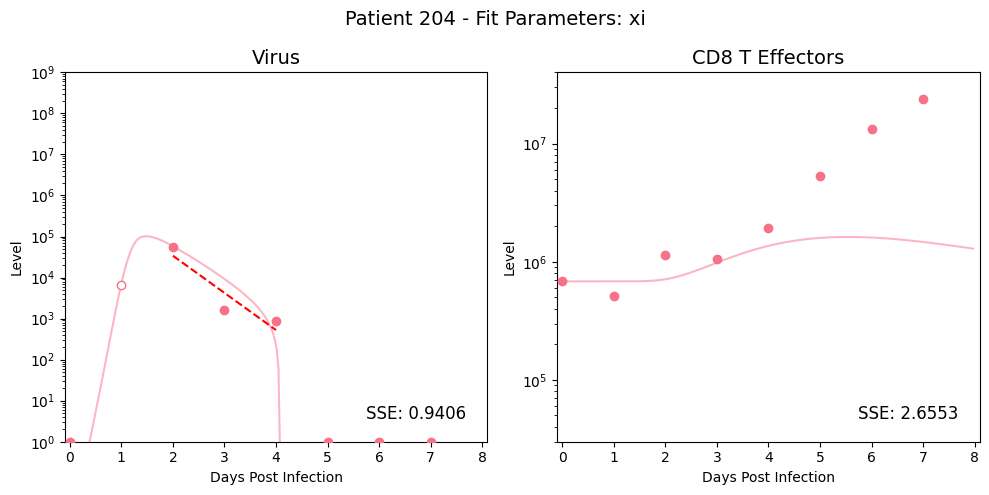

Processing Combination 2: Parameters set to 'fit' -> ('a',)
             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 5.275745694906754
                   x: [ 4.027e-01]
                 nit: 10
                nfev: 165
          population: [[ 4.027e-01]
                       [ 3.782e-01]
                       ...
                       [ 3.973e-01]
                       [ 3.741e-01]]
 population_energies: [ 5.276e+00  5.359e+00 ...  5.374e+00  5.377e+00]


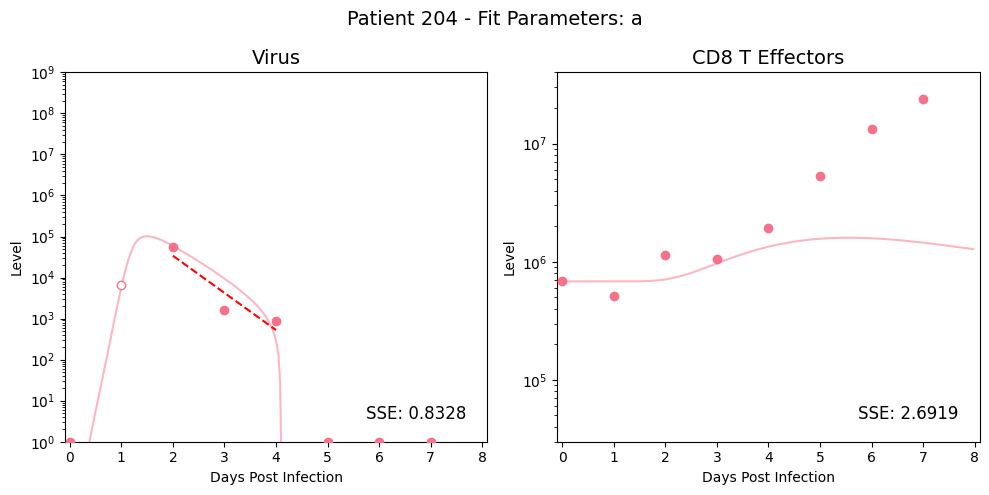

Processing Combination 3: Parameters set to 'fit' -> ('tau',)


KeyboardInterrupt: 

In [6]:
combination_number = 1
process_combinations(combinations_1D, combination_number, ids, df, t_span, states, output_dir, subplot_configuration)

In [7]:
combination_number = 7
process_combinations(combinations_2D, combination_number, ids, df, t_span, states, output_dir, subplot_configuration)

Processing Combination 7: Parameters set to 'fit' -> ('xi', 'a')


Processing Combination 22: Parameters set to 'fit' -> ('xi', 'a', 'tau')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.291520276259864
                   x: [ 8.844e-01  6.657e-02  7.063e-01]
                 nit: 10
                nfev: 495
          population: [[ 8.844e-01  6.657e-02  7.063e-01]
                       [ 6.174e-01  8.910e-02  6.453e-01]
                       ...
                       [ 8.876e-01  6.594e-02  7.047e-01]
                       [ 8.836e-01  6.656e-02  7.023e-01]]
 population_energies: [ 3.292e+00  3.300e+00 ...  3.292e+00  3.292e+00]


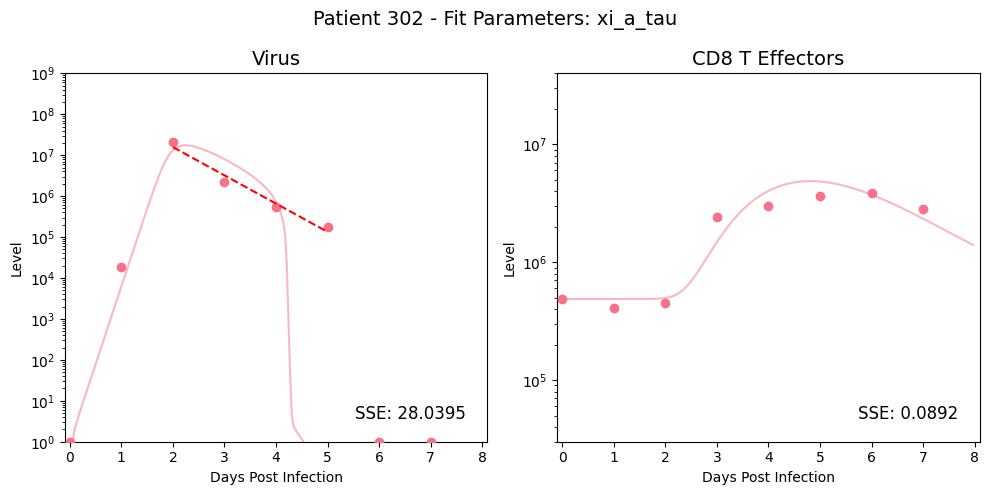

Processing Combination 23: Parameters set to 'fit' -> ('xi', 'a', 'd_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.289088213619257
                   x: [ 8.990e+00  1.266e+00  9.587e+01]
                 nit: 5
                nfev: 270
          population: [[ 8.990e+00  1.266e+00  9.587e+01]
                       [ 8.723e+00  1.276e+00  9.746e+01]
                       ...
                       [ 7.377e+00  1.222e+00  7.932e+01]
                       [ 8.197e+00  1.370e+00  9.491e+01]]
 population_energies: [ 3.289e+00  3.290e+00 ...  3.290e+00  3.289e+00]


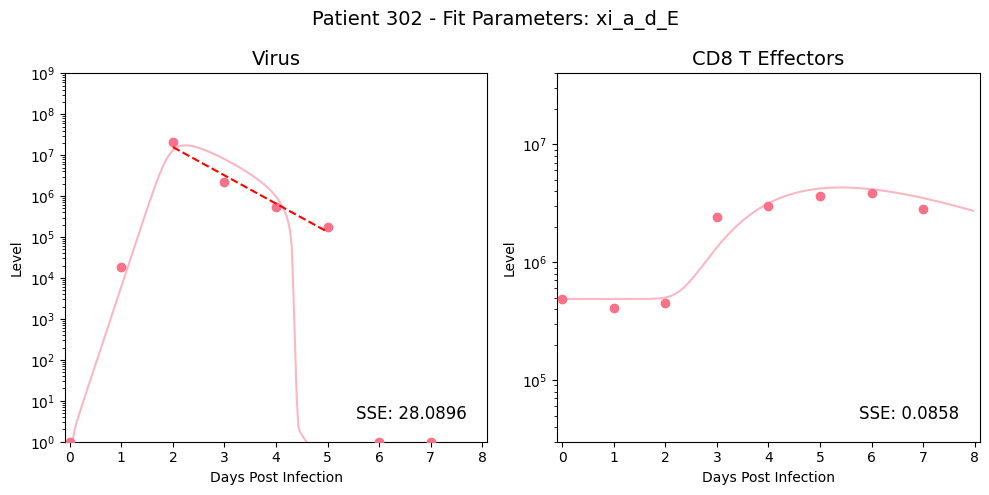

Processing Combination 24: Parameters set to 'fit' -> ('xi', 'a', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.4847703162884516
                   x: [ 8.991e-01  2.004e-01  2.687e+01]
                 nit: 9
                nfev: 450
          population: [[ 8.991e-01  2.004e-01  2.687e+01]
                       [ 1.008e+00  1.885e-01  1.861e+01]
                       ...
                       [ 9.116e-01  1.980e-01  2.653e+01]
                       [ 8.917e-01  1.909e-01  2.824e+01]]
 population_energies: [ 3.485e+00  3.490e+00 ...  3.485e+00  3.486e+00]


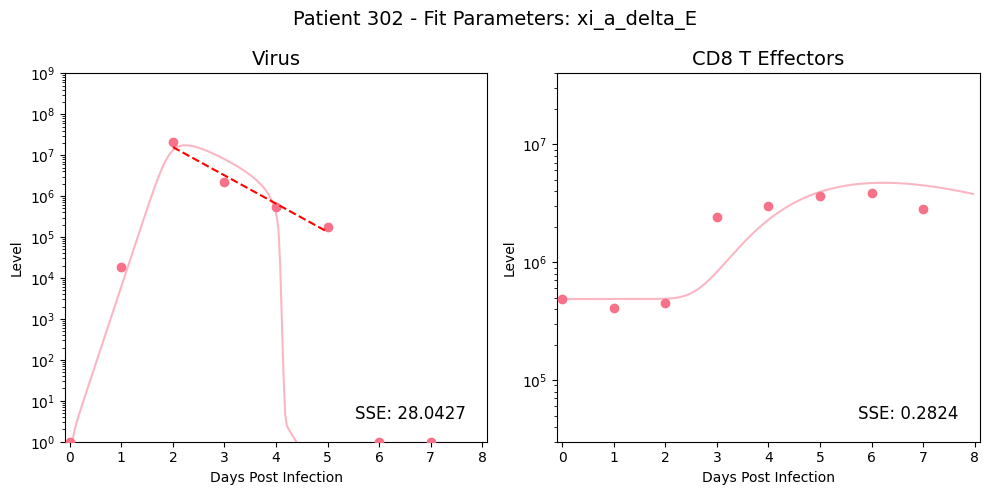

Processing Combination 25: Parameters set to 'fit' -> ('xi', 'a', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.2207347710416325
                   x: [ 4.317e-02  2.542e+00  9.985e+05]
                 nit: 9
                nfev: 450
          population: [[ 4.317e-02  2.542e+00  9.985e+05]
                       [ 4.466e-02  2.399e+00  9.140e+05]
                       ...
                       [ 4.379e-02  2.601e+00  9.599e+05]
                       [ 4.773e-02  1.836e+00  9.788e+05]]
 population_energies: [ 3.221e+00  3.239e+00 ...  3.230e+00  3.277e+00]


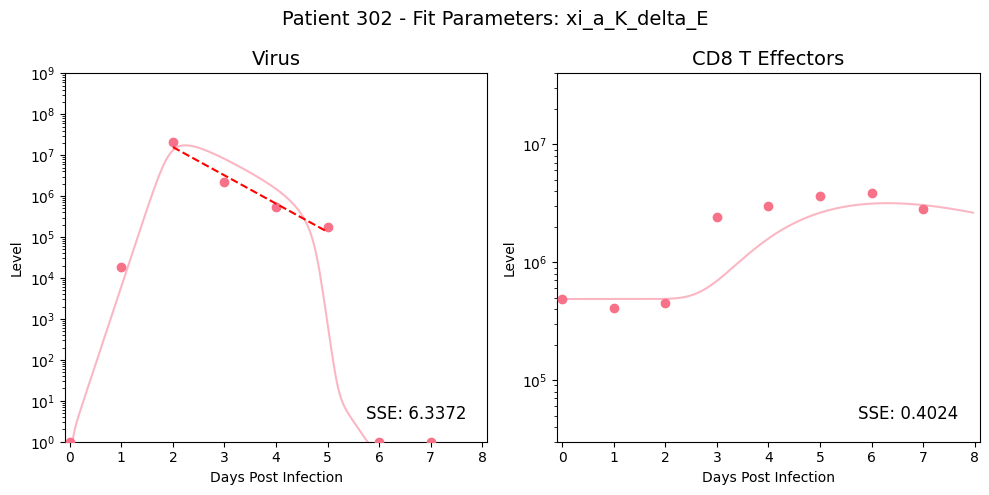

Processing Combination 26: Parameters set to 'fit' -> ('xi', 'tau', 'd_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.251522740799133
                   x: [ 8.013e+00  1.058e+00  3.882e+01]
                 nit: 4
                nfev: 225
          population: [[ 8.013e+00  1.058e+00  3.882e+01]
                       [ 7.642e+00  1.011e+00  3.938e+01]
                       ...
                       [ 8.128e+00  1.084e+00  3.844e+01]
                       [ 8.019e+00  1.071e+00  3.861e+01]]
 population_energies: [ 3.252e+00  3.254e+00 ...  3.252e+00  3.252e+00]


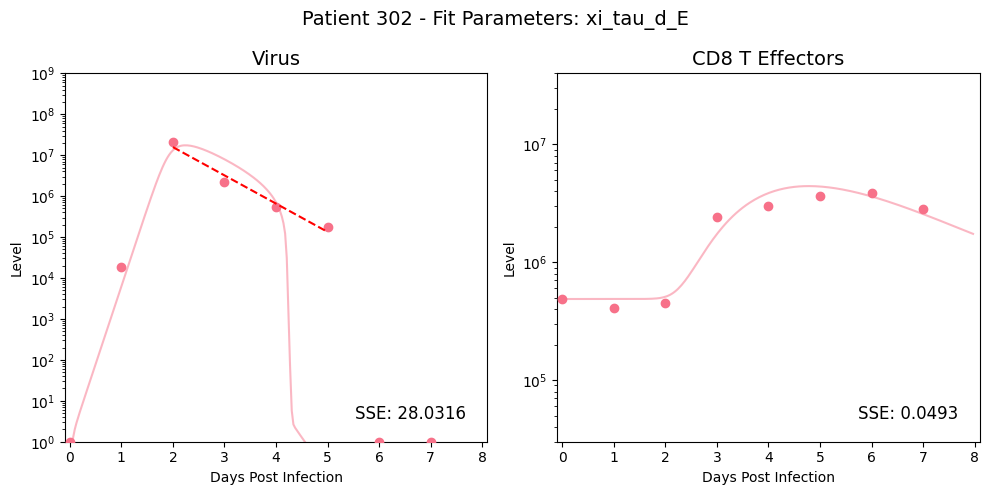

Processing Combination 27: Parameters set to 'fit' -> ('xi', 'tau', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.8050419154585597
                   x: [ 1.439e-01  6.717e-01  6.844e-01]
                 nit: 10
                nfev: 495
          population: [[ 1.439e-01  6.717e-01  6.844e-01]
                       [ 1.823e-01  6.743e-01  5.016e-01]
                       ...
                       [ 1.430e-01  6.693e-01  7.133e-01]
                       [ 1.463e-01  6.708e-01  6.137e-01]]
 population_energies: [ 2.805e+00  2.839e+00 ...  2.805e+00  2.805e+00]


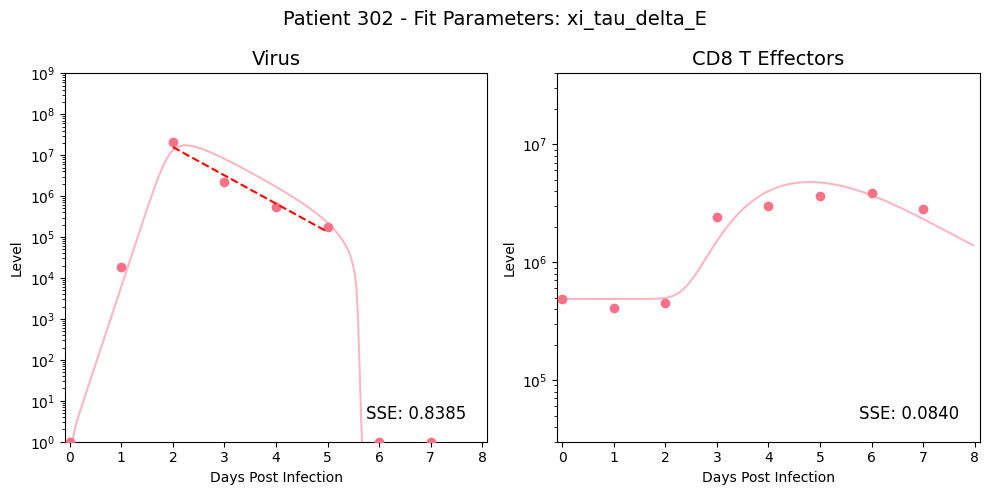

Processing Combination 28: Parameters set to 'fit' -> ('xi', 'tau', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.111322745175329
                   x: [ 1.459e-01  7.090e-01  9.678e+05]
                 nit: 7
                nfev: 360
          population: [[ 1.459e-01  7.090e-01  9.678e+05]
                       [ 1.566e-01  7.559e-01  4.468e+05]
                       ...
                       [ 1.671e-01  7.463e-01  6.122e+05]
                       [ 1.380e-01  6.816e-01  8.879e+05]]
 population_energies: [ 3.111e+00  3.168e+00 ...  3.143e+00  3.119e+00]


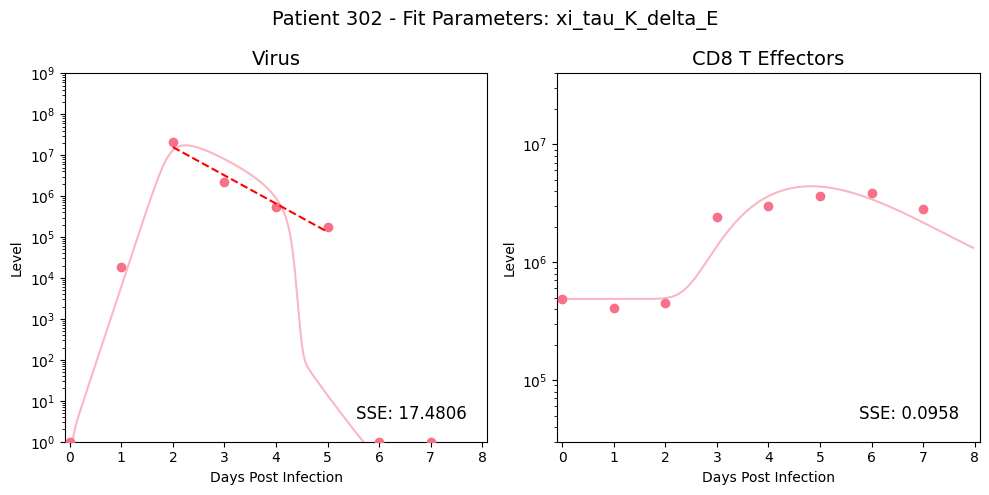

Processing Combination 29: Parameters set to 'fit' -> ('xi', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.818715162056332
                   x: [ 9.881e+00  3.167e+01  1.436e+00]
                 nit: 10
                nfev: 495
          population: [[ 9.881e+00  3.167e+01  1.436e+00]
                       [ 9.242e+00  3.237e+01  1.798e+00]
                       ...
                       [ 8.943e+00  3.437e+01  2.232e+00]
                       [ 9.431e+00  2.845e+01  1.175e+00]]
 population_energies: [ 2.819e+00  2.825e+00 ...  2.843e+00  2.821e+00]


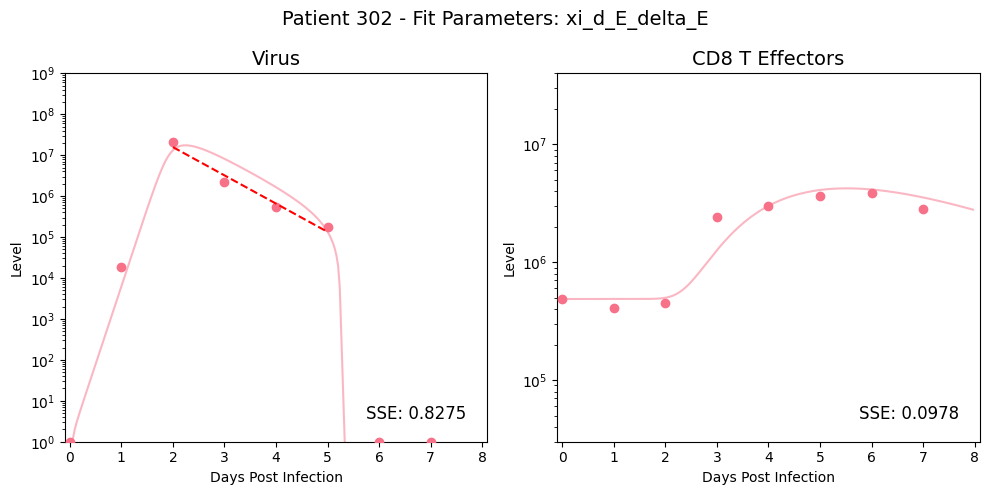

Processing Combination 30: Parameters set to 'fit' -> ('xi', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.1020134471897145
                   x: [ 9.251e+00  3.016e+01  9.820e+05]
                 nit: 4
                nfev: 225
          population: [[ 9.251e+00  3.016e+01  9.820e+05]
                       [ 8.120e+00  2.736e+01  9.773e+05]
                       ...
                       [ 8.290e+00  2.654e+01  9.734e+05]
                       [ 7.749e+00  2.558e+01  3.690e+05]]
 population_energies: [ 3.102e+00  3.104e+00 ...  3.104e+00  3.171e+00]


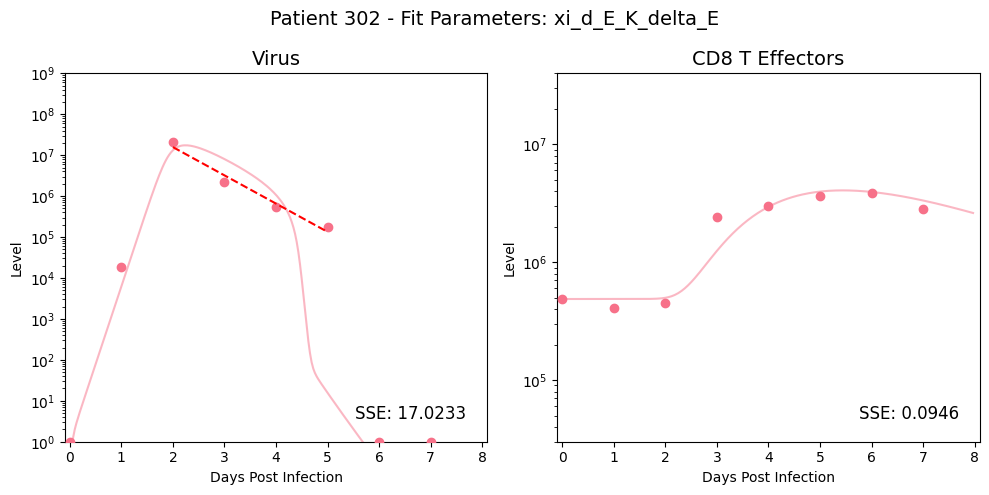

Processing Combination 31: Parameters set to 'fit' -> ('xi', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.016985098547199
                   x: [ 4.786e-01  1.916e+00  3.923e+05]
                 nit: 6
                nfev: 315
          population: [[ 4.786e-01  1.916e+00  3.923e+05]
                       [ 4.991e-01  1.705e+00  3.023e+05]
                       ...
                       [ 4.753e-01  1.930e+00  3.975e+05]
                       [ 4.789e-01  1.952e+00  3.486e+05]]
 population_energies: [ 3.017e+00  3.018e+00 ...  3.017e+00  3.017e+00]


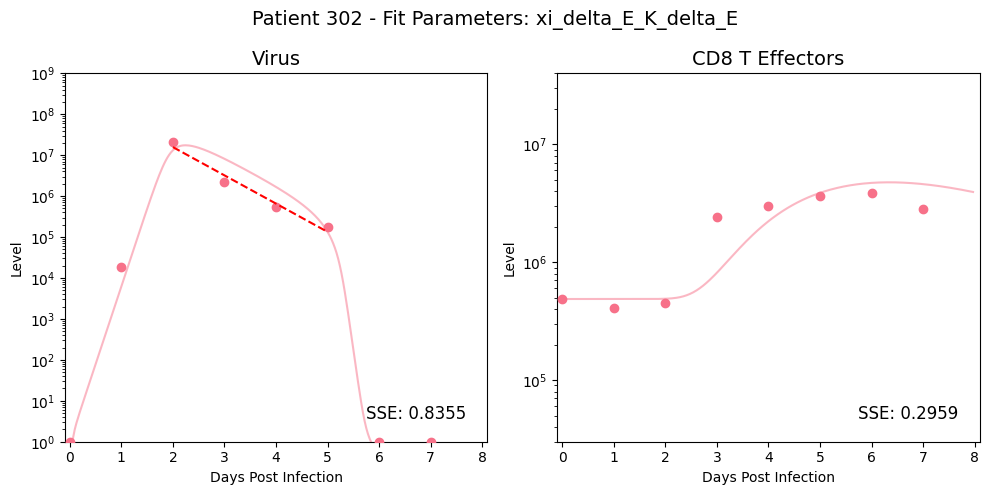

Processing Combination 32: Parameters set to 'fit' -> ('a', 'tau', 'd_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.255633779641591
                   x: [ 9.389e+00  1.020e+00  1.593e+01]
                 nit: 4
                nfev: 225
          population: [[ 9.389e+00  1.020e+00  1.593e+01]
                       [ 9.317e+00  1.048e+00  1.160e+01]
                       ...
                       [ 9.360e+00  1.007e+00  1.737e+01]
                       [ 9.661e+00  9.701e-01  1.698e+01]]
 population_energies: [ 3.256e+00  3.301e+00 ...  3.259e+00  3.260e+00]


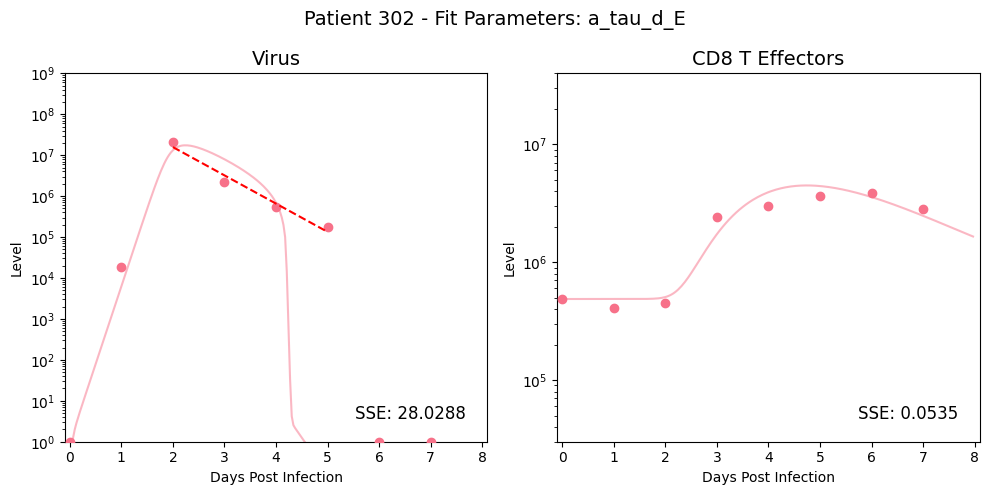

Processing Combination 33: Parameters set to 'fit' -> ('a', 'tau', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.805152430435213
                   x: [ 4.399e-01  6.767e-01  9.333e-01]
                 nit: 12
                nfev: 585
          population: [[ 4.399e-01  6.767e-01  9.333e-01]
                       [ 3.756e-01  6.642e-01  1.306e+00]
                       ...
                       [ 4.354e-01  6.668e-01  1.040e+00]
                       [ 4.072e-01  6.805e-01  4.983e-01]]
 population_energies: [ 2.805e+00  2.818e+00 ...  2.806e+00  2.810e+00]


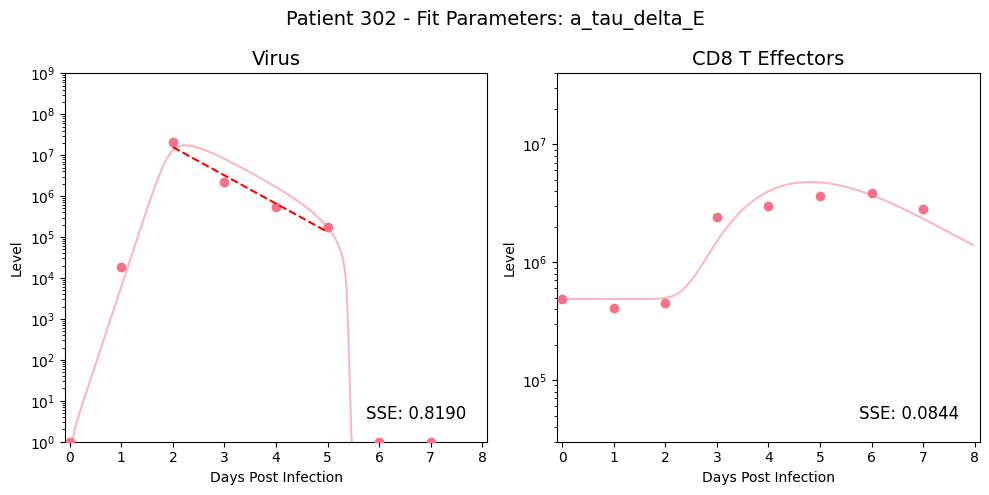

Processing Combination 34: Parameters set to 'fit' -> ('a', 'tau', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.1079282433839204
                   x: [ 4.653e-01  7.038e-01  9.963e+05]
                 nit: 8
                nfev: 405
          population: [[ 4.653e-01  7.038e-01  9.963e+05]
                       [ 4.823e-01  7.449e-01  9.873e+05]
                       ...
                       [ 4.596e-01  6.895e-01  9.899e+05]
                       [ 4.576e-01  7.005e-01  9.878e+05]]
 population_energies: [ 3.108e+00  3.110e+00 ...  3.109e+00  3.109e+00]


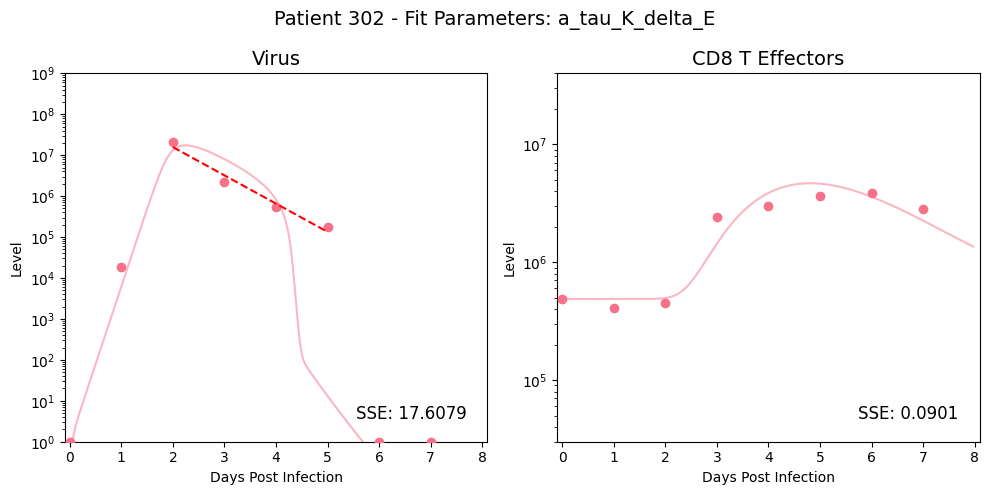

Processing Combination 35: Parameters set to 'fit' -> ('a', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.839252703110719
                   x: [ 9.619e+00  1.024e+01  1.556e+00]
                 nit: 7
                nfev: 360
          population: [[ 9.619e+00  1.024e+01  1.556e+00]
                       [ 7.040e+00  7.663e+00  1.048e+00]
                       ...
                       [ 8.773e+00  9.316e+00  8.440e-01]
                       [ 7.597e+00  8.140e+00  1.153e+00]]
 population_energies: [ 2.839e+00  2.852e+00 ...  2.843e+00  2.848e+00]


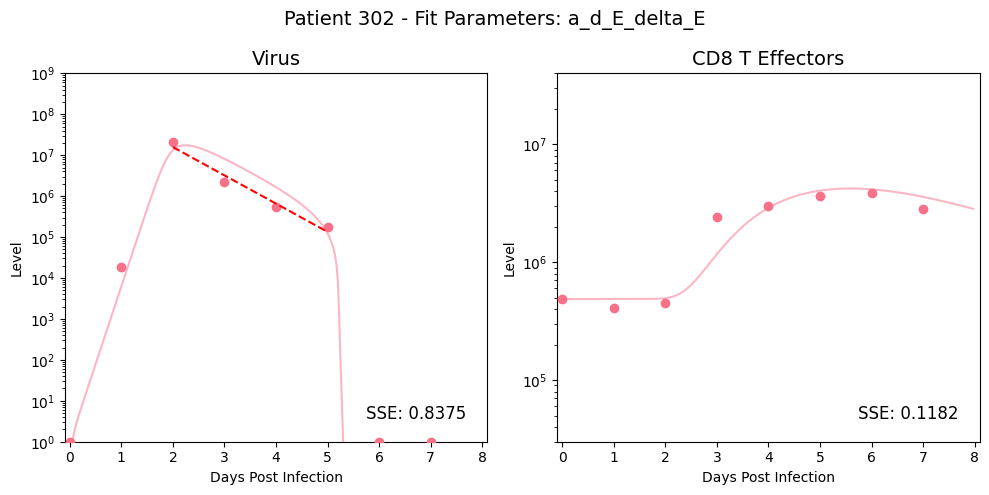

Processing Combination 36: Parameters set to 'fit' -> ('a', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.1198523888187593
                   x: [ 9.974e+00  1.063e+01  9.924e+05]
                 nit: 7
                nfev: 360
          population: [[ 9.974e+00  1.063e+01  9.924e+05]
                       [ 5.842e+00  5.923e+00  9.586e+05]
                       ...
                       [ 9.995e+00  1.138e+01  9.238e+05]
                       [ 6.032e+00  7.668e+00  9.765e+05]]
 population_energies: [ 3.120e+00  3.146e+00 ...  3.125e+00  3.151e+00]


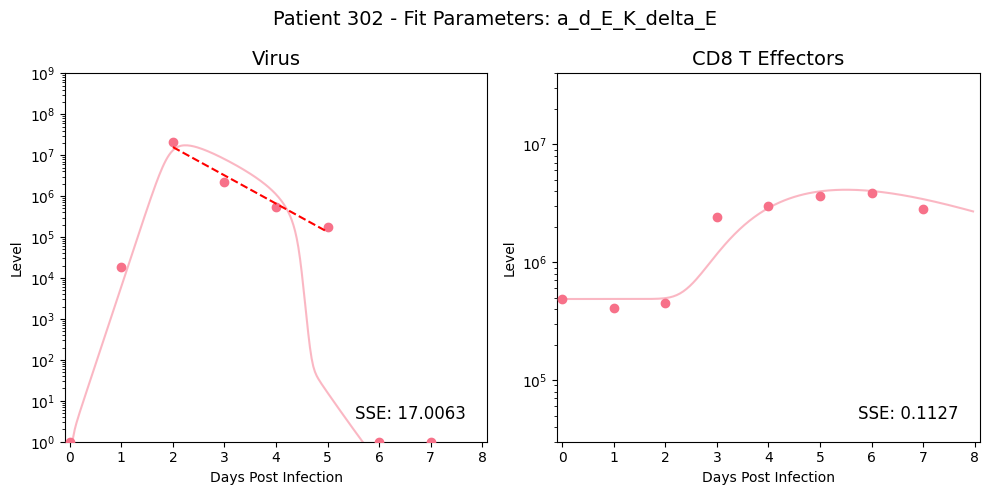

Processing Combination 37: Parameters set to 'fit' -> ('a', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.0170410363962774
                   x: [ 1.448e+00  1.774e+00  4.277e+05]
                 nit: 8
                nfev: 405
          population: [[ 1.448e+00  1.774e+00  4.277e+05]
                       [ 1.449e+00  1.409e+00  3.588e+05]
                       ...
                       [ 1.395e+00  2.165e+00  4.117e+05]
                       [ 1.325e+00  2.137e+00  4.095e+05]]
 population_energies: [ 3.017e+00  3.018e+00 ...  3.018e+00  3.021e+00]


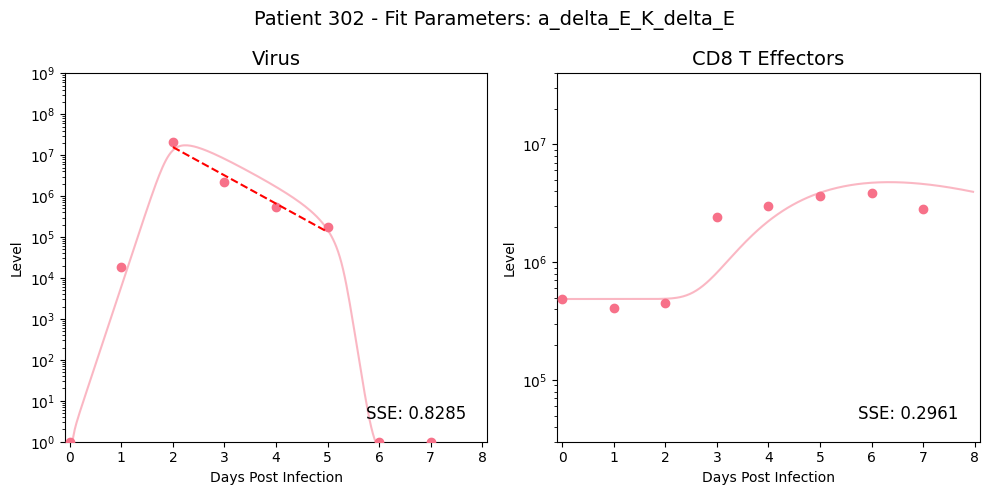

Processing Combination 38: Parameters set to 'fit' -> ('tau', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.803465621795225
                   x: [ 6.407e-01  1.070e+00  8.338e-01]
                 nit: 14
                nfev: 675
          population: [[ 6.407e-01  1.070e+00  8.338e-01]
                       [ 6.236e-01  1.081e+00  6.764e-01]
                       ...
                       [ 6.386e-01  1.072e+00  9.806e-01]
                       [ 6.367e-01  1.086e+00  6.571e-01]]
 population_energies: [ 2.803e+00  2.804e+00 ...  2.804e+00  2.804e+00]


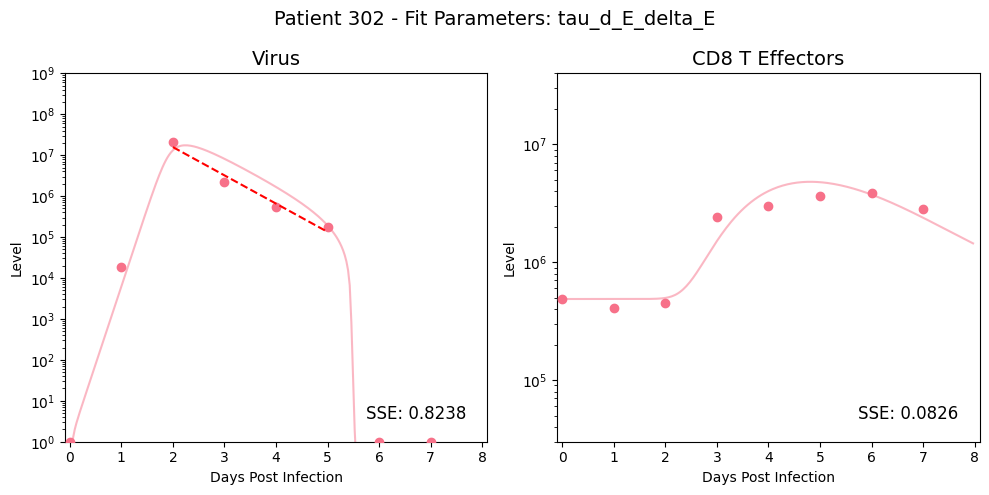

Processing Combination 39: Parameters set to 'fit' -> ('tau', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.142496764319787
                   x: [ 6.676e-01  9.864e-01  5.850e+05]
                 nit: 6
                nfev: 315
          population: [[ 6.676e-01  9.864e-01  5.850e+05]
                       [ 6.607e-01  9.416e-01  3.834e+05]
                       ...
                       [ 6.700e-01  8.283e-01  6.089e+05]
                       [ 6.761e-01  9.544e-01  5.878e+05]]
 population_energies: [ 3.142e+00  3.176e+00 ...  3.159e+00  3.144e+00]


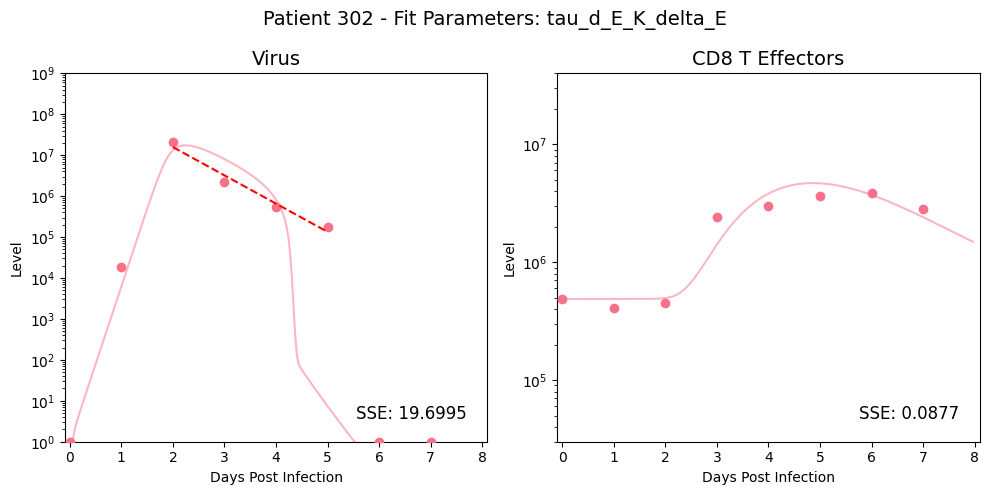

Processing Combination 40: Parameters set to 'fit' -> ('tau', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.8247696936704654
                   x: [ 5.942e-01  1.558e+00  4.930e+05]
                 nit: 6
                nfev: 315
          population: [[ 5.942e-01  1.558e+00  4.930e+05]
                       [ 6.316e-01  2.131e+00  6.969e+05]
                       ...
                       [ 5.758e-01  1.858e+00  6.080e+05]
                       [ 5.974e-01  1.723e+00  5.586e+05]]
 population_energies: [ 2.825e+00  2.828e+00 ...  2.837e+00  2.826e+00]


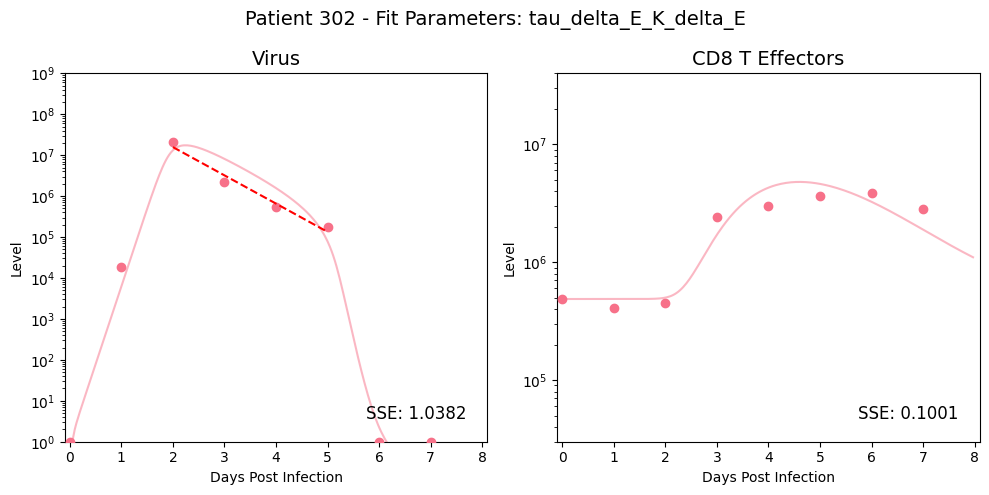

Processing Combination 41: Parameters set to 'fit' -> ('d_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 3.3291758724265974
                   x: [ 1.010e-01  3.979e+00  7.345e+05]
                 nit: 10
                nfev: 495
          population: [[ 1.010e-01  3.979e+00  7.345e+05]
                       [ 1.075e-01  4.276e+00  7.259e+05]
                       ...
                       [ 1.127e-01  4.606e+00  7.286e+05]
                       [ 1.571e-01  5.582e+00  7.192e+05]]
 population_energies: [ 3.329e+00  3.329e+00 ...  3.330e+00  3.335e+00]


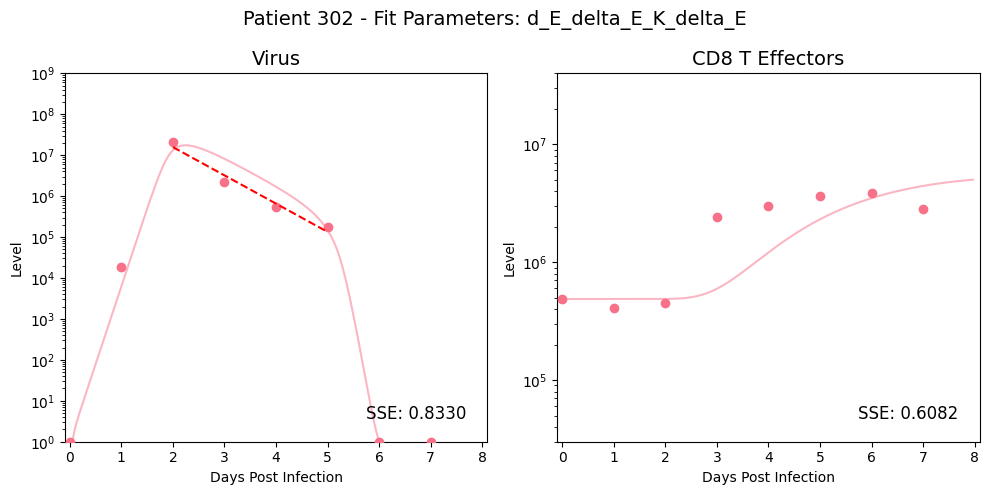

In [ ]:
combination_number = 22
process_combinations(combinations_3D, combination_number, ids, df, t_span, states, output_dir, subplot_configuration)

Processing Combination 42: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'd_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.65427464169431
                   x: [ 1.532e+00  3.066e-01  2.139e+00  9.734e+00]
                 nit: 26
                nfev: 1620
          population: [[ 1.532e+00  3.066e-01  2.139e+00  9.734e+00]
                       [ 1.612e+00  3.171e-01  2.183e+00  9.472e+00]
                       ...
                       [ 1.609e+00  3.265e-01  2.147e+00  1.061e+01]
                       [ 1.834e+00  4.682e-01  2.209e+00  1.551e+01]]
 population_energies: [ 2.654e+00  2.679e+00 ...  2.671e+00  2.683e+00]


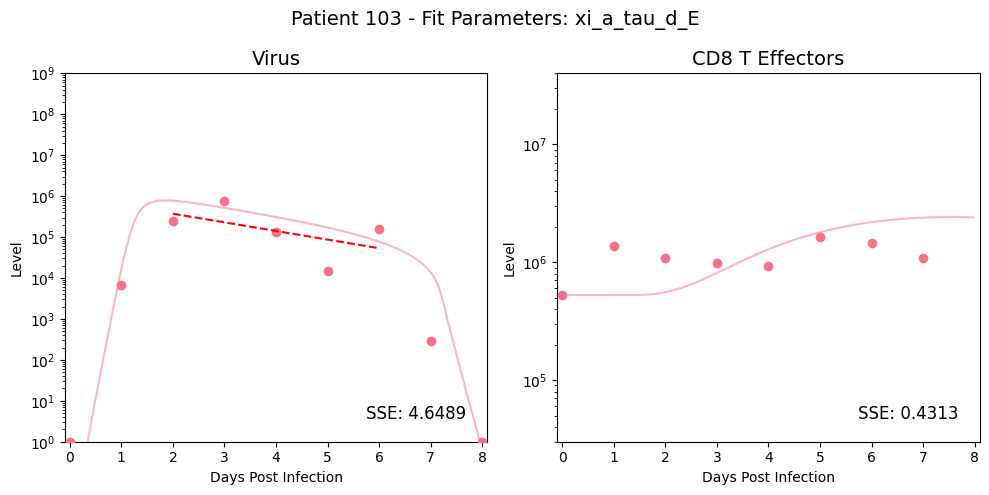

Processing Combination 43: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9444482918944943
                   x: [ 1.797e-02  4.112e-01  1.126e+00  3.210e+01]
                 nit: 23
                nfev: 1440
          population: [[ 1.797e-02  4.112e-01  1.126e+00  3.210e+01]
                       [ 2.246e-02  4.434e-01  1.246e+00  2.847e+01]
                       ...
                       [ 1.616e-02  4.075e-01  1.047e+00  3.079e+01]
                       [ 2.192e-02  4.029e-01  1.217e+00  3.151e+01]]
 population_energies: [ 1.944e+00  1.956e+00 ...  1.954e+00  1.948e+00]


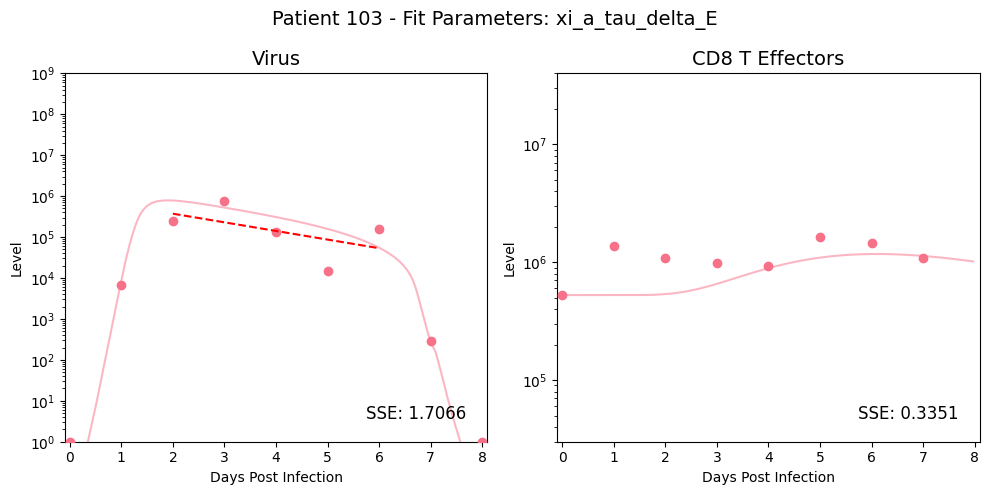

Processing Combination 44: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.8313741917812587
                   x: [ 1.205e+00  3.224e-01  3.828e+00  2.502e+05]
                 nit: 18
                nfev: 1140
          population: [[ 1.205e+00  3.224e-01  3.828e+00  2.502e+05]
                       [ 1.093e+00  3.681e-01  3.703e+00  2.172e+05]
                       ...
                       [ 1.017e+00  5.308e-01  3.838e+00  2.561e+05]
                       [ 1.071e+00  4.216e-01  3.626e+00  1.560e+05]]
 population_energies: [ 2.831e+00  2.877e+00 ...  2.951e+00  2.929e+00]


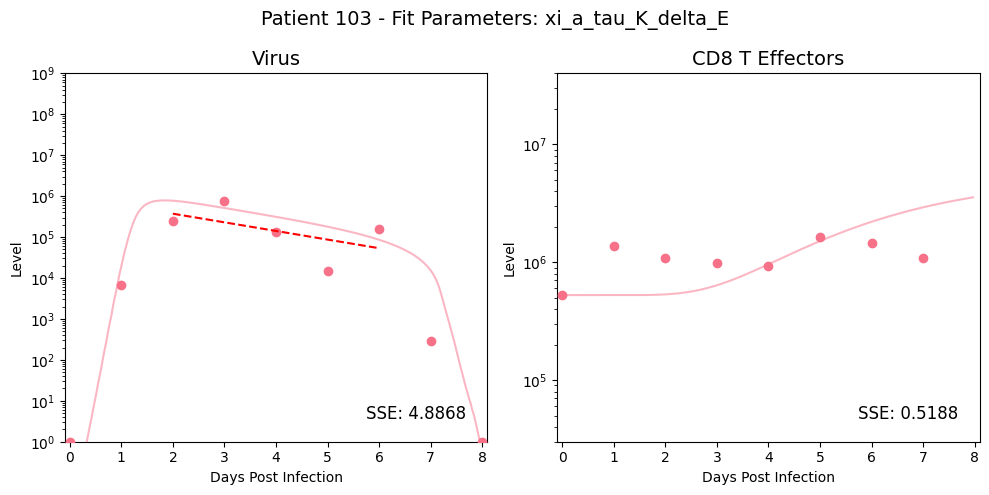

Processing Combination 45: Parameters set to 'fit' -> ('xi', 'a', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9696369437117203
                   x: [ 3.583e-01  1.690e+00  9.303e+01  3.684e+01]
                 nit: 10
                nfev: 660
          population: [[ 3.583e-01  1.690e+00  9.303e+01  3.684e+01]
                       [ 3.793e-01  1.715e+00  9.412e+01  3.201e+01]
                       ...
                       [ 3.634e-01  1.834e+00  9.348e+01  3.423e+01]
                       [ 3.546e-01  1.779e+00  9.405e+01  3.520e+01]]
 population_energies: [ 1.970e+00  1.994e+00 ...  1.984e+00  1.981e+00]


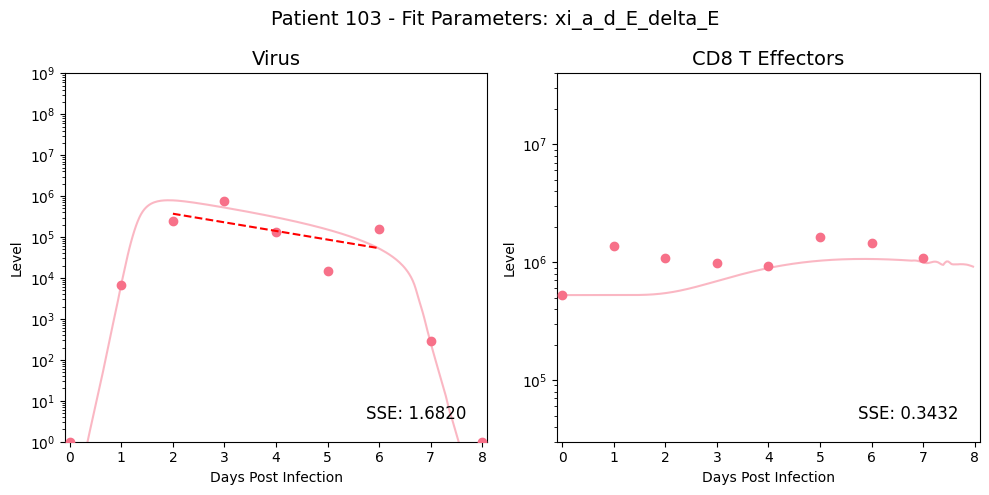

Processing Combination 46: Parameters set to 'fit' -> ('xi', 'a', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.7758014639826563
                   x: [ 4.069e+01  4.338e-02  8.863e+01  1.072e+05]
                 nit: 18
                nfev: 1140
          population: [[ 4.069e+01  4.338e-02  8.863e+01  1.072e+05]
                       [ 4.748e+01  3.927e-02  9.141e+01  1.286e+05]
                       ...
                       [ 3.927e+01  4.726e-02  8.889e+01  3.233e+05]
                       [ 4.173e+01  4.335e-02  9.040e+01  9.490e+04]]
 population_energies: [ 2.776e+00  2.817e+00 ...  2.815e+00  2.797e+00]


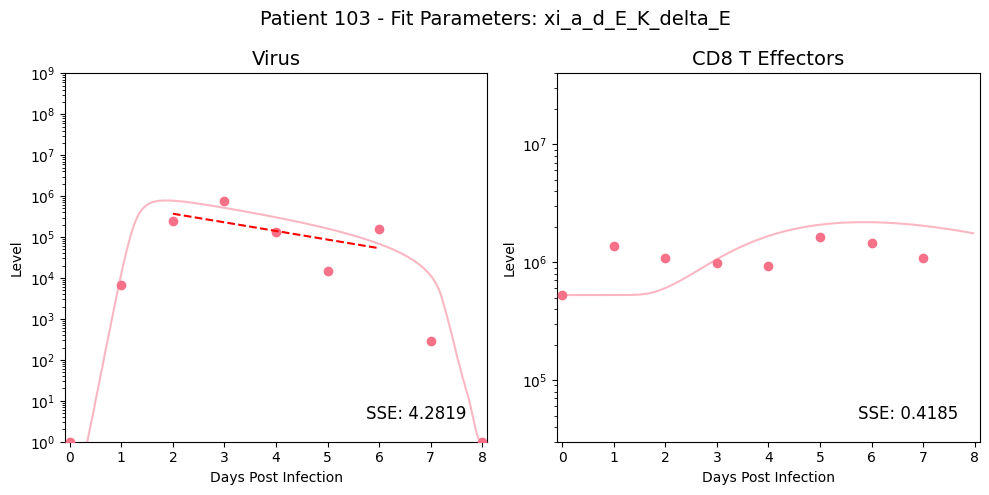

Processing Combination 47: Parameters set to 'fit' -> ('xi', 'a', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9557519688202492
                   x: [ 6.725e-02  1.573e-01  3.588e+01  7.184e+05]
                 nit: 14
                nfev: 900
          population: [[ 6.725e-02  1.573e-01  3.588e+01  7.184e+05]
                       [ 6.391e-02  1.285e-01  4.138e+01  5.794e+05]
                       ...
                       [ 6.529e-02  1.457e-01  3.922e+01  6.511e+05]
                       [ 7.671e-02  1.149e-01  4.207e+01  5.676e+05]]
 population_energies: [ 1.956e+00  1.989e+00 ...  1.958e+00  1.963e+00]


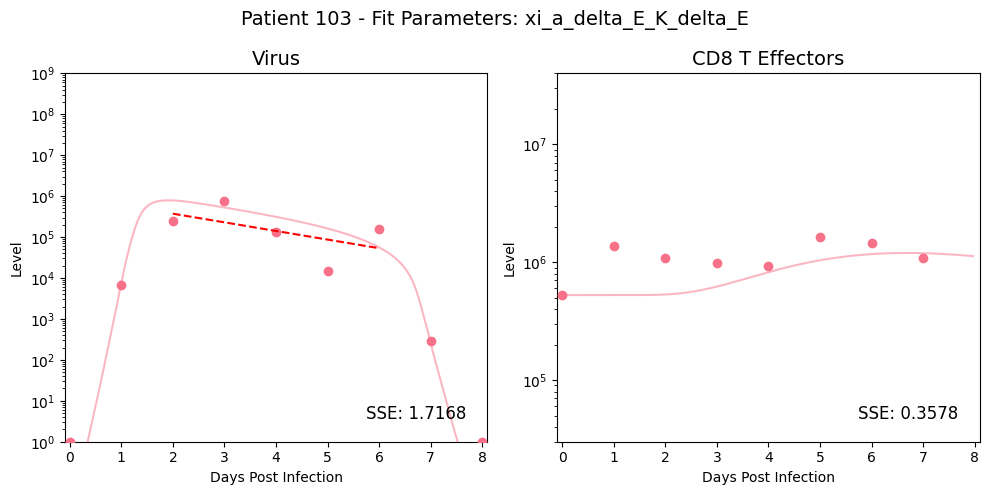

Processing Combination 48: Parameters set to 'fit' -> ('xi', 'tau', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9686172307008323
                   x: [ 2.425e+00  1.672e+00  8.931e+01  3.464e+01]
                 nit: 13
                nfev: 840
          population: [[ 2.425e+00  1.672e+00  8.931e+01  3.464e+01]
                       [ 3.660e+00  1.867e+00  8.768e+01  2.997e+01]
                       ...
                       [ 2.446e+00  1.649e+00  9.152e+01  3.406e+01]
                       [ 2.500e+00  1.640e+00  9.254e+01  3.495e+01]]
 population_energies: [ 1.969e+00  1.990e+00 ...  1.975e+00  1.985e+00]


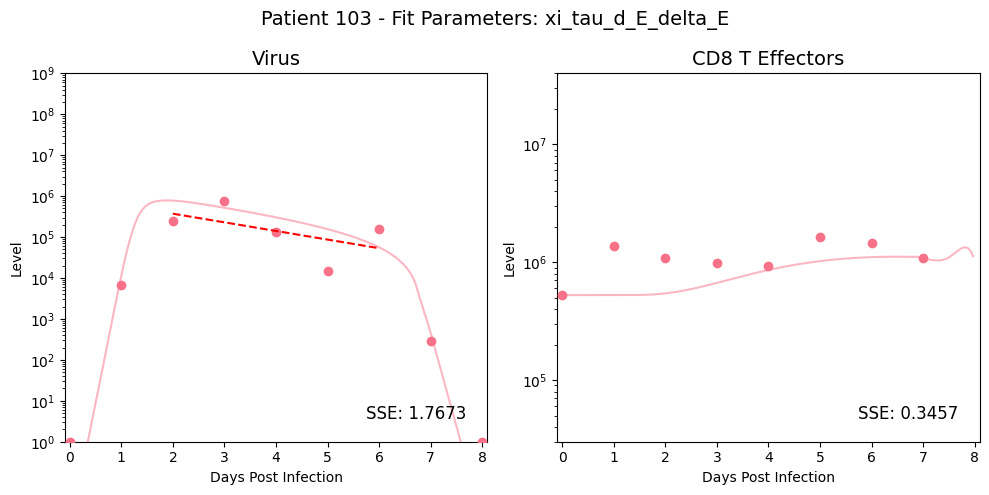

Processing Combination 49: Parameters set to 'fit' -> ('xi', 'tau', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.6689185008894296
                   x: [ 1.567e+01  2.294e+00  9.907e+01  9.891e+04]
                 nit: 16
                nfev: 1020
          population: [[ 1.567e+01  2.294e+00  9.907e+01  9.891e+04]
                       [ 1.596e+01  2.294e+00  9.900e+01  7.844e+04]
                       ...
                       [ 1.459e+01  2.262e+00  9.164e+01  1.343e+05]
                       [ 2.070e+01  2.521e+00  9.717e+01  4.841e+04]]
 population_energies: [ 2.669e+00  2.676e+00 ...  2.701e+00  2.698e+00]


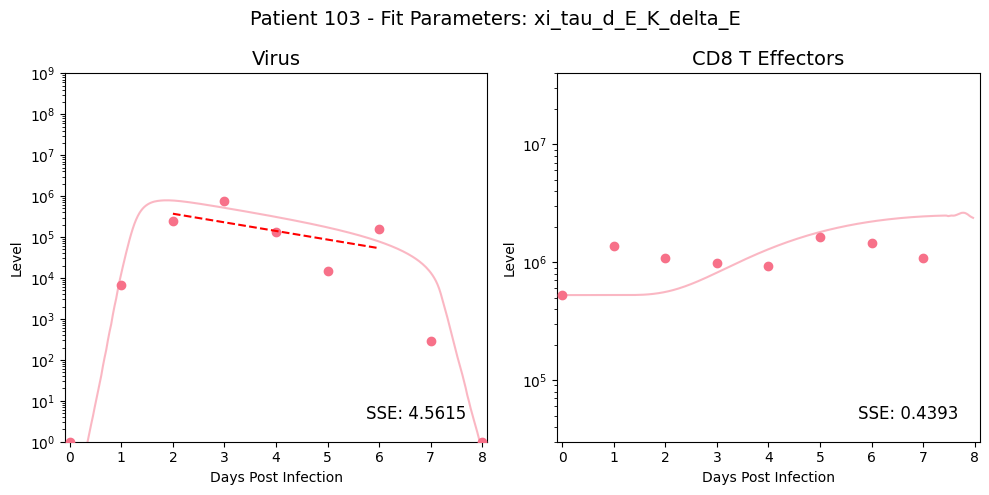

Processing Combination 50: Parameters set to 'fit' -> ('xi', 'tau', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9419484240298552
                   x: [ 1.846e-02  1.107e+00  3.641e+01  3.638e+05]
                 nit: 18
                nfev: 1140
          population: [[ 1.846e-02  1.107e+00  3.641e+01  3.638e+05]
                       [ 1.892e-02  1.106e+00  3.484e+01  3.690e+05]
                       ...
                       [ 1.982e-02  1.127e+00  3.338e+01  3.717e+05]
                       [ 1.923e-02  1.116e+00  3.532e+01  3.687e+05]]
 population_energies: [ 1.942e+00  1.943e+00 ...  1.945e+00  1.952e+00]


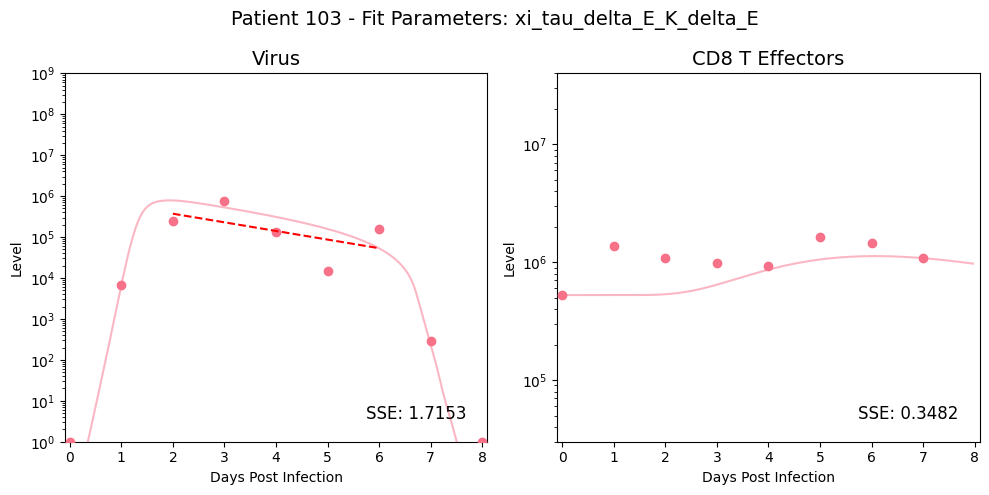

Processing Combination 51: Parameters set to 'fit' -> ('xi', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.973520682985852
                   x: [ 1.541e+00  8.710e+01  4.090e+01  7.880e+05]
                 nit: 11
                nfev: 720
          population: [[ 1.541e+00  8.710e+01  4.090e+01  7.880e+05]
                       [ 1.285e+00  8.340e+01  4.511e+01  8.753e+05]
                       ...
                       [ 1.428e+00  8.187e+01  3.876e+01  2.163e+05]
                       [ 1.400e+00  8.412e+01  4.116e+01  5.645e+05]]
 population_energies: [ 1.974e+00  2.002e+00 ...  1.986e+00  1.987e+00]


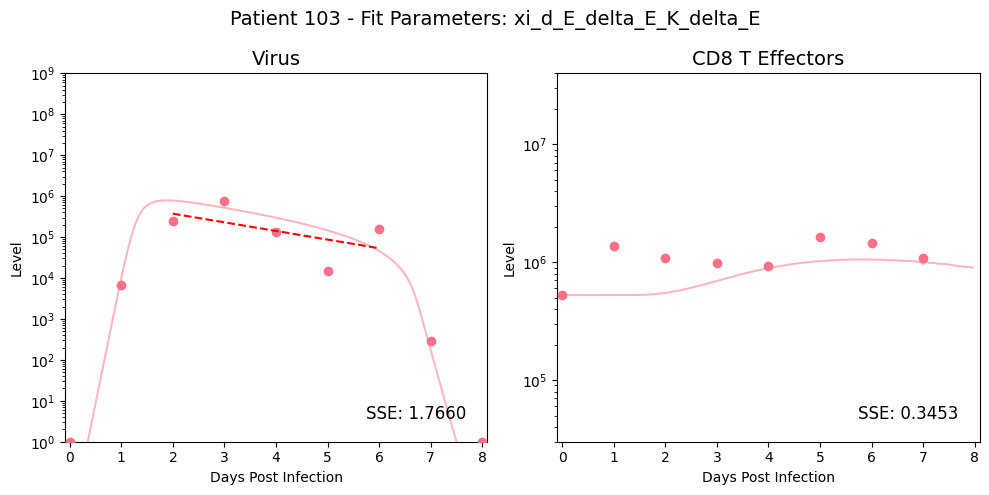

Processing Combination 52: Parameters set to 'fit' -> ('a', 'tau', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9680686466585624
                   x: [ 3.698e+00  1.584e+00  4.393e+01  3.105e+01]
                 nit: 5
                nfev: 360
          population: [[ 3.698e+00  1.584e+00  4.393e+01  3.105e+01]
                       [ 3.990e+00  1.610e+00  4.283e+01  3.001e+01]
                       ...
                       [ 4.018e+00  1.451e+00  7.039e+01  3.958e+01]
                       [ 4.115e+00  1.497e+00  5.577e+01  3.355e+01]]
 population_energies: [ 1.968e+00  1.983e+00 ...  1.989e+00  1.979e+00]


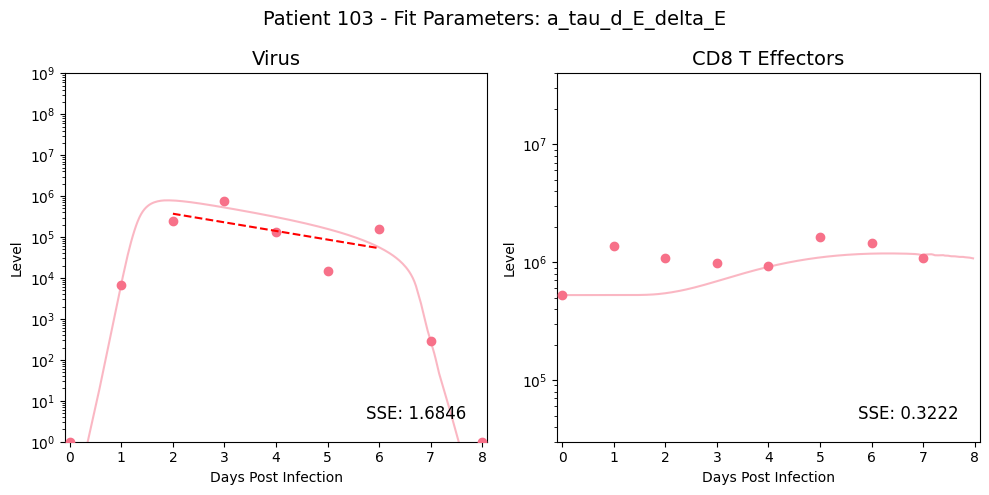

Processing Combination 53: Parameters set to 'fit' -> ('a', 'tau', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.700932167383678
                   x: [ 9.621e+00  2.048e+00  2.485e+01  3.541e+05]
                 nit: 12
                nfev: 780
          population: [[ 9.621e+00  2.048e+00  2.485e+01  3.541e+05]
                       [ 9.296e+00  2.008e+00  2.467e+01  3.431e+05]
                       ...
                       [ 9.463e+00  1.897e+00  2.841e+01  3.626e+05]
                       [ 9.582e+00  1.974e+00  2.698e+01  3.471e+05]]
 population_energies: [ 2.701e+00  2.712e+00 ...  2.723e+00  2.702e+00]


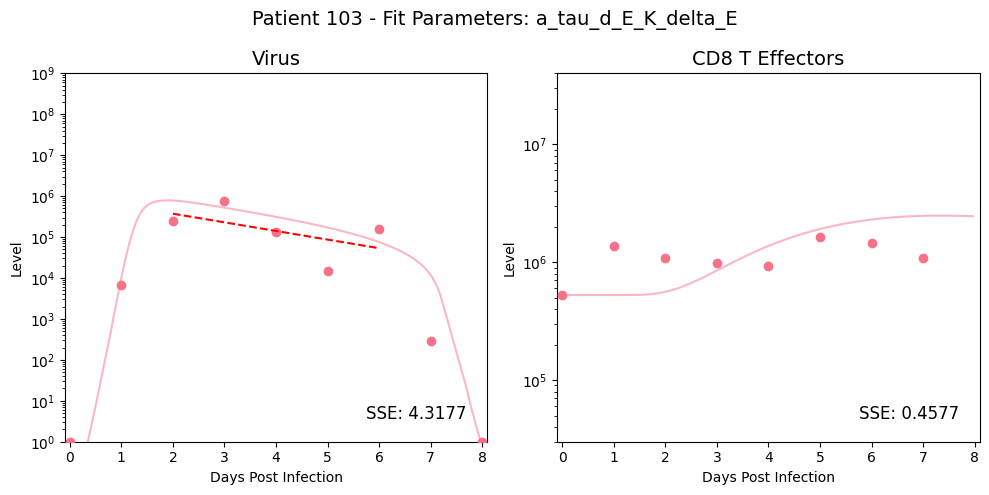

Processing Combination 54: Parameters set to 'fit' -> ('a', 'tau', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9470364036011278
                   x: [ 7.472e-02  1.242e+00  3.277e+01  2.384e+05]
                 nit: 13
                nfev: 840
          population: [[ 7.472e-02  1.242e+00  3.277e+01  2.384e+05]
                       [ 7.103e-02  1.122e+00  2.707e+01  9.786e+04]
                       ...
                       [ 8.168e-02  1.257e+00  3.073e+01  4.002e+05]
                       [ 7.627e-02  1.244e+00  3.254e+01  2.819e+05]]
 population_energies: [ 1.947e+00  1.966e+00 ...  1.955e+00  1.958e+00]


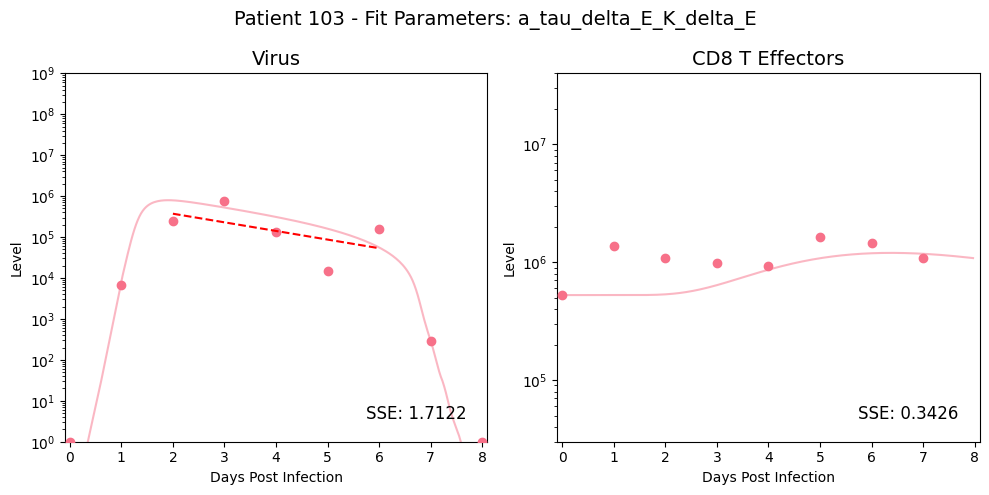

Processing Combination 55: Parameters set to 'fit' -> ('a', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9771620316160943
                   x: [ 4.462e+00  7.715e+01  3.665e+01  4.494e+05]
                 nit: 7
                nfev: 480
          population: [[ 4.462e+00  7.715e+01  3.665e+01  4.494e+05]
                       [ 4.607e+00  8.041e+01  3.592e+01  4.513e+05]
                       ...
                       [ 4.698e+00  8.073e+01  3.609e+01  4.431e+05]
                       [ 4.646e+00  8.078e+01  3.661e+01  4.330e+05]]
 population_energies: [ 1.977e+00  1.988e+00 ...  1.978e+00  1.978e+00]


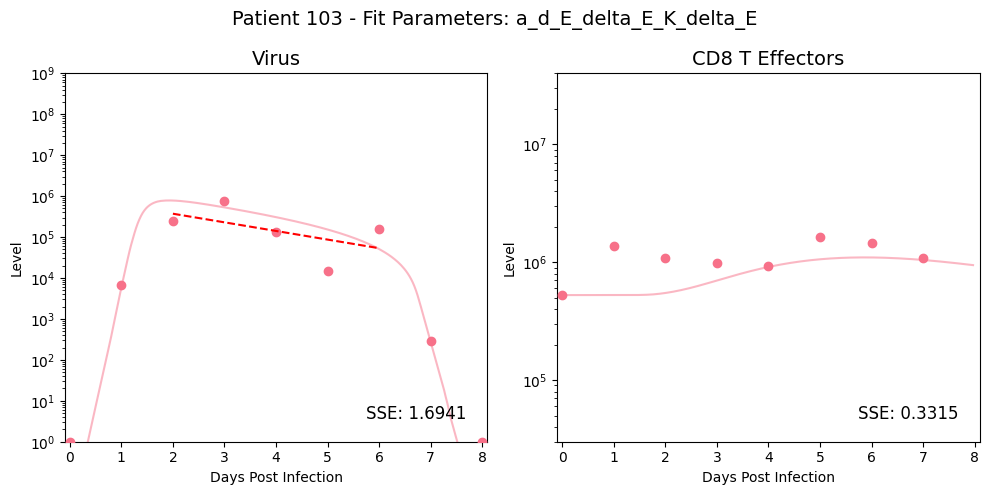

Processing Combination 56: Parameters set to 'fit' -> ('tau', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9633442082479515
                   x: [ 1.548e+00  4.816e+00  3.600e+01  4.909e+05]
                 nit: 9
                nfev: 600
          population: [[ 1.548e+00  4.816e+00  3.600e+01  4.909e+05]
                       [ 1.562e+00  4.705e+00  3.564e+01  4.886e+05]
                       ...
                       [ 1.514e+00  5.031e+00  3.553e+01  4.913e+05]
                       [ 1.608e+00  4.585e+00  3.617e+01  4.932e+05]]
 population_energies: [ 1.963e+00  1.967e+00 ...  1.965e+00  1.970e+00]


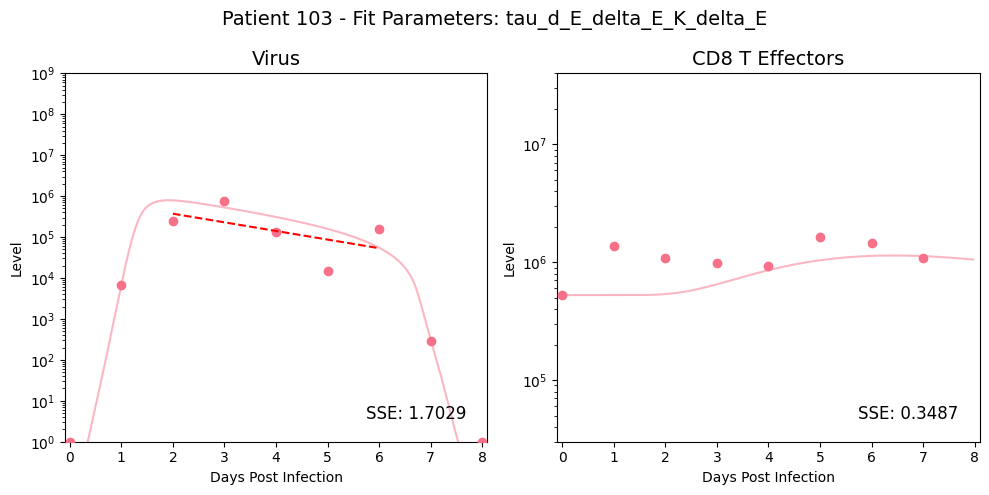

In [7]:
combination_number = 42
process_combinations(combinations_4D, combination_number, ids, df, t_span, states, output_dir, subplot_configuration)

Processing Combination 57: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'd_E', 'delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9794327824257907
                   x: [ 4.688e+00  1.222e-01  2.040e+00  3.945e+01
                        3.852e+01]
                 nit: 15
                nfev: 1200
          population: [[ 4.688e+00  1.222e-01 ...  3.945e+01  3.852e+01]
                       [ 4.496e+00  1.167e-01 ...  3.910e+01  4.046e+01]
                       ...
                       [ 4.589e+00  1.221e-01 ...  3.875e+01  3.803e+01]
                       [ 4.594e+00  1.267e-01 ...  3.906e+01  3.843e+01]]
 population_energies: [ 1.979e+00  1.992e+00 ...  1.993e+00  1.991e+00]


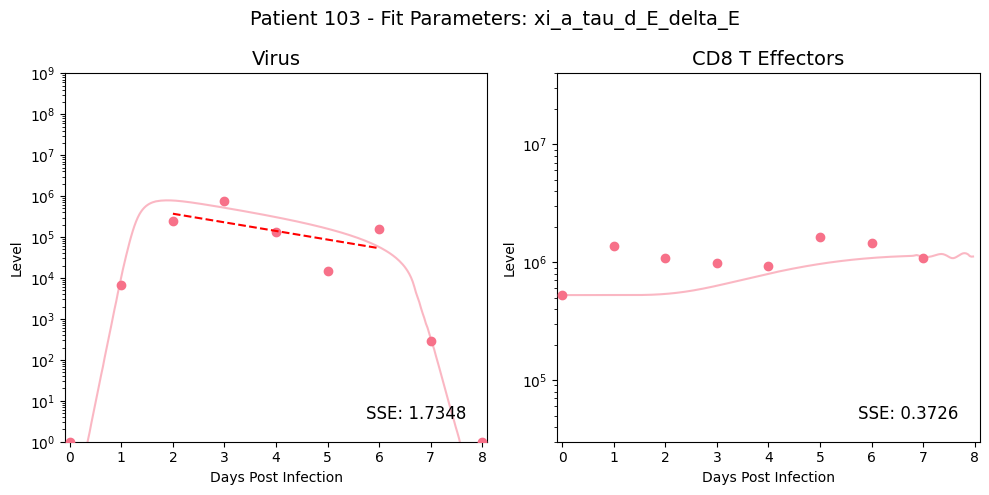

Processing Combination 58: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'd_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 2.6979290068092445
                   x: [ 3.175e+01  2.302e-01  2.505e+00  9.808e+01
                        2.290e+05]
                 nit: 23
                nfev: 1800
          population: [[ 3.175e+01  2.302e-01 ...  9.808e+01  2.290e+05]
                       [ 3.463e+01  2.367e-01 ...  9.951e+01  5.136e+05]
                       ...
                       [ 3.354e+01  2.386e-01 ...  9.856e+01  3.980e+05]
                       [ 3.492e+01  2.420e-01 ...  9.656e+01  4.968e+05]]
 population_energies: [ 2.698e+00  2.740e+00 ...  2.713e+00  2.734e+00]


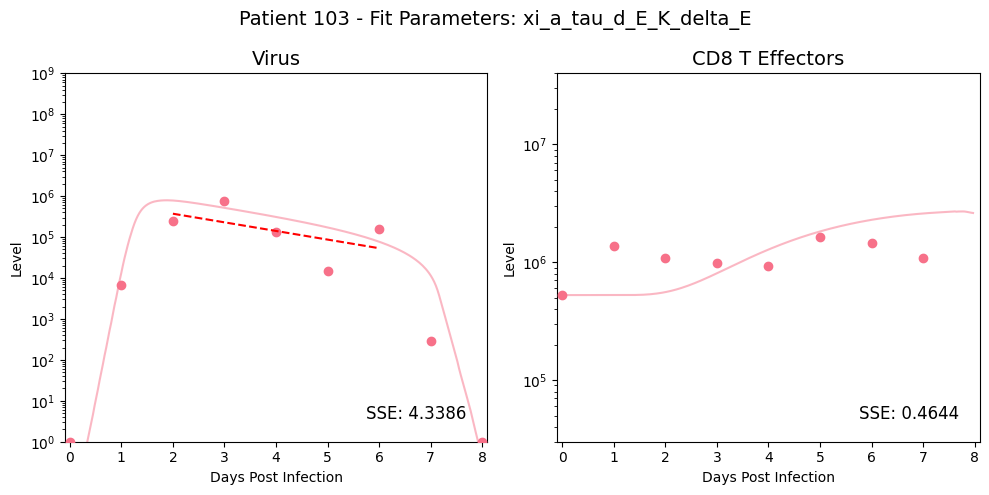

Processing Combination 59: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9454499674648231
                   x: [ 1.150e-01  5.996e-02  1.174e+00  3.789e+01
                        2.082e+05]
                 nit: 22
                nfev: 1725
          population: [[ 1.150e-01  5.996e-02 ...  3.789e+01  2.082e+05]
                       [ 1.034e-01  5.695e-02 ...  3.828e+01  2.200e+05]
                       ...
                       [ 1.484e-01  4.976e-02 ...  3.801e+01  2.408e+05]
                       [ 1.356e-01  4.880e-02 ...  3.878e+01  1.969e+05]]
 population_energies: [ 1.945e+00  1.955e+00 ...  1.957e+00  1.954e+00]


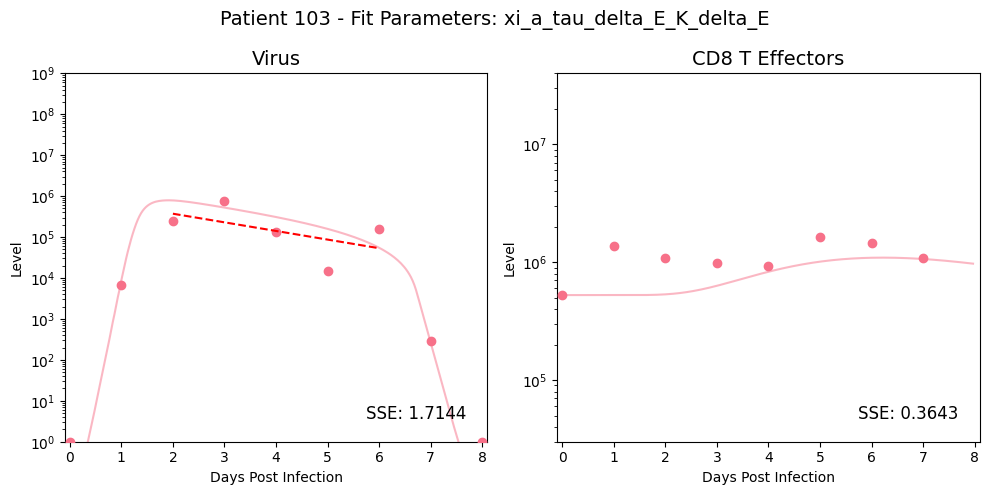

Processing Combination 60: Parameters set to 'fit' -> ('xi', 'a', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.977350749101389
                   x: [ 2.548e-01  2.415e+00  9.087e+01  3.631e+01
                        3.717e+05]
                 nit: 15
                nfev: 1200
          population: [[ 2.548e-01  2.415e+00 ...  3.631e+01  3.717e+05]
                       [ 2.827e-01  2.352e+00 ...  3.416e+01  3.423e+05]
                       ...
                       [ 2.482e-01  2.471e+00 ...  3.662e+01  3.570e+05]
                       [ 2.626e-01  2.422e+00 ...  3.528e+01  3.475e+05]]
 population_energies: [ 1.977e+00  1.980e+00 ...  1.979e+00  1.983e+00]


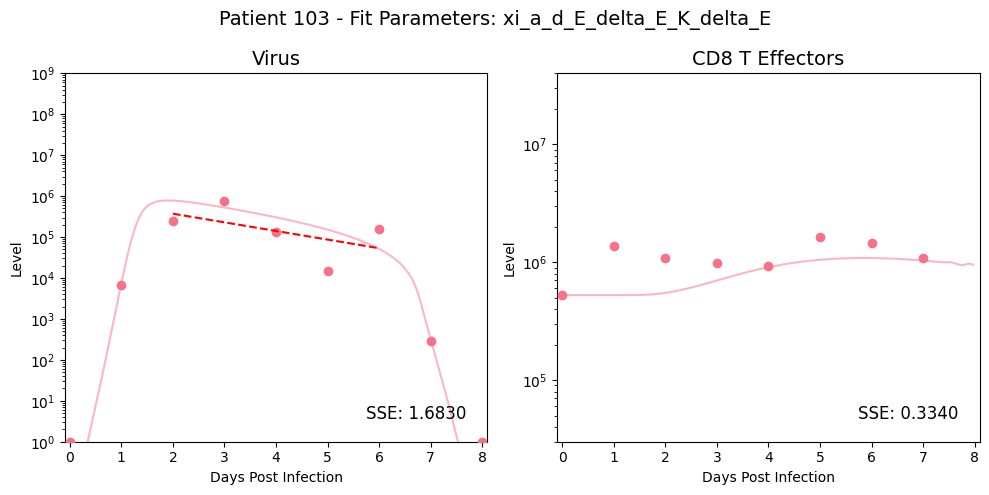

Processing Combination 61: Parameters set to 'fit' -> ('xi', 'tau', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9523537102957473
                   x: [ 2.675e+00  1.821e+00  8.079e+01  3.755e+01
                        6.549e+05]
                 nit: 10
                nfev: 825
          population: [[ 2.675e+00  1.821e+00 ...  3.755e+01  6.549e+05]
                       [ 2.340e+00  1.720e+00 ...  3.860e+01  7.474e+05]
                       ...
                       [ 2.810e+00  1.813e+00 ...  3.598e+01  6.832e+05]
                       [ 2.797e+00  1.891e+00 ...  3.840e+01  6.483e+05]]
 population_energies: [ 1.952e+00  1.979e+00 ...  1.978e+00  1.984e+00]


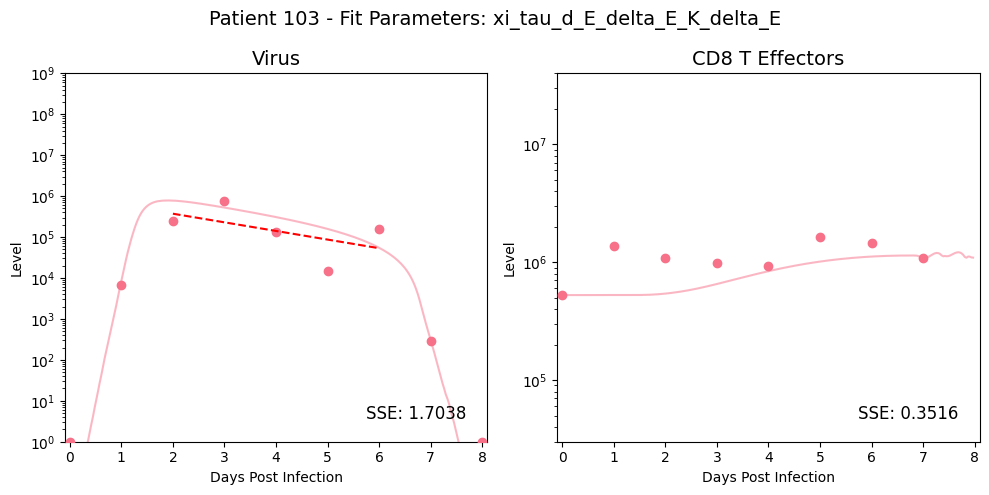

Processing Combination 62: Parameters set to 'fit' -> ('a', 'tau', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9712282253857236
                   x: [ 3.786e+00  1.528e+00  5.609e+01  3.838e+01
                        6.201e+05]
                 nit: 8
                nfev: 675
          population: [[ 3.786e+00  1.528e+00 ...  3.838e+01  6.201e+05]
                       [ 3.558e+00  1.537e+00 ...  4.052e+01  6.567e+05]
                       ...
                       [ 3.959e+00  1.538e+00 ...  3.772e+01  6.181e+05]
                       [ 3.769e+00  1.453e+00 ...  3.568e+01  6.141e+05]]
 population_energies: [ 1.971e+00  1.978e+00 ...  1.972e+00  1.975e+00]


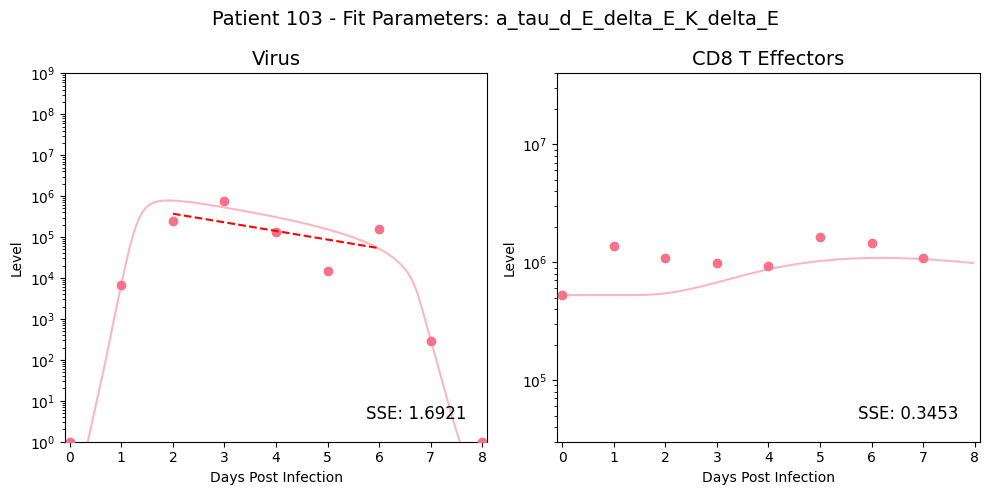

In [8]:
combination_number = 57
process_combinations(combinations_5D, combination_number, ids, df, t_span, states, output_dir, subplot_configuration)

Processing Combination 63: Parameters set to 'fit' -> ('xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E')
             message: Optimization terminated successfully.
             success: True
                 fun: 1.9714973742236324
                   x: [ 1.243e+00  5.337e-01  1.532e+00  8.059e+01
                        3.722e+01  4.530e+05]
                 nit: 18
                nfev: 1710
          population: [[ 1.243e+00  5.337e-01 ...  3.722e+01  4.530e+05]
                       [ 1.365e+00  5.450e-01 ...  3.726e+01  4.763e+05]
                       ...
                       [ 1.632e+00  5.346e-01 ...  3.956e+01  4.972e+05]
                       [ 1.108e+00  4.865e-01 ...  3.699e+01  4.757e+05]]
 population_energies: [ 1.971e+00  1.978e+00 ...  1.985e+00  1.982e+00]


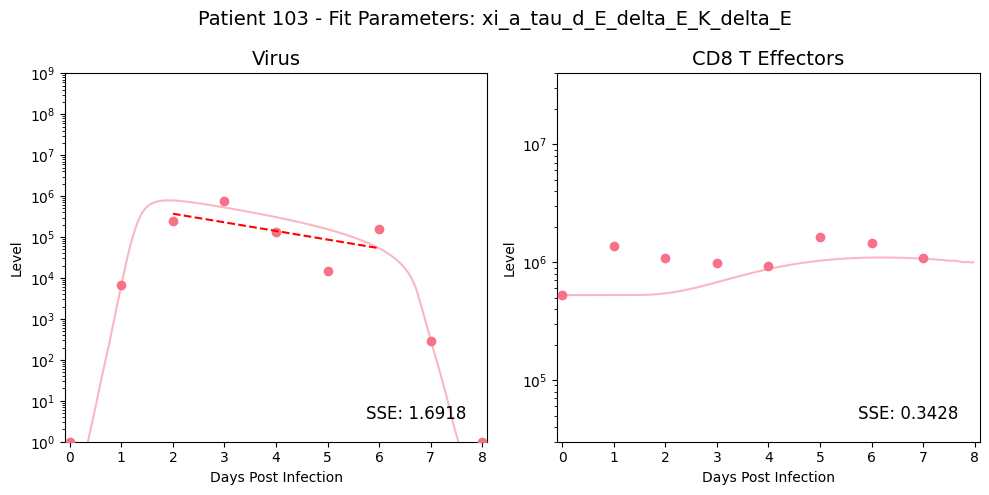

In [9]:
combination_number = 63
process_combinations(combinations_6D, combination_number, ids, df, t_span, states, output_dir, subplot_configuration)